In [61]:
import sys
sys.path.append("../")
from src import prepro, metrics, run, setup
import src.models.factory as model_factory
import config
import torch

import numpy as np
from src.utils import models
import os.path as osp
import pandas as pd

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from src.utils.data_processing import *
from sklearn.linear_model import Lasso

window_size = 8
predict_at = 8
full = False

tgt_intensity_cat_train = torch.LongTensor(np.load('../data/y_train_intensity_cat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                      allow_pickle=True))
tgt_intensity_cat_test = torch.LongTensor(np.load('../data/y_test_intensity_cat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                     allow_pickle=True))

tgt_intensity_train = torch.Tensor(np.load('../data/y_train_intensity_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                  allow_pickle=True))
tgt_intensity_test = torch.Tensor(np.load('../data/y_test_intensity_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                 allow_pickle=True))

tgt_intensity_cat_baseline_train = torch.LongTensor(np.load('../data/y_train_intensity_cat_baseline_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',  allow_pickle = True))
tgt_intensity_cat_baseline_test = torch.LongTensor(np.load('../data/y_test_intensity_cat_baseline_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy', allow_pickle=True))

def standardize(tgt_displacement_train, tgt_displacement_test):
    mean_dx = tgt_displacement_train[:, 0].mean()
    std_dx = tgt_displacement_train[:, 0].std()
    tgt_displacement_train[:, 0] = (tgt_displacement_train[:, 0] - mean_dx) / std_dx
    tgt_displacement_test[:, 0] = (tgt_displacement_test[:, 0] - mean_dx) / std_dx
    std_dx = float(std_dx)
    mean_dx = float(mean_dx)
    mean_dy = tgt_displacement_train[:, 1].mean()
    std_dy = tgt_displacement_train[:, 1].std()
    tgt_displacement_train[:, 1] = (tgt_displacement_train[:, 1] - mean_dy) / std_dy
    tgt_displacement_test[:, 1] = (tgt_displacement_test[:, 1] - mean_dy) / std_dy
    std_dy = float(std_dy)
    mean_dy = float(mean_dy)
    return tgt_displacement_train, tgt_displacement_test, std_dx, mean_dx, std_dy, mean_dy

def unstandardize(tgt_displacement_train, tgt_displacement_test, std_dx, mean_dx, std_dy, mean_dy):
    tgt_displacement_train[:, 0] = tgt_displacement_train[:, 0] *  std_dx + mean_dx
    tgt_displacement_test[:, 0] = tgt_displacement_test[:, 0] *  std_dx + mean_dx
    tgt_displacement_train[:, 1] = tgt_displacement_train[:, 1] * std_dy + mean_dy
    tgt_displacement_test[:, 1] = tgt_displacement_test[:, 1] * std_dy + mean_dy
    return tgt_displacement_train, tgt_displacement_test


##########
##########
########## PREPARING DATA FOR XGB

X_train = np.load('../data/X_train_stat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
            allow_pickle=True)
X_test = np.load('../data/X_test_stat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
            allow_pickle=True)


names = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
         'STORM_SPEED', 'cat_cos_day', 'cat_sign_day', 'COS_STORM_DIR', 'SIN_STORM_DIR',
         'COS_LAT', 'SIN_LAT', 'COS_LON', 'SIN_LON', 'cat_storm_category', 'cat_basin_AN',
         'cat_basin_EP', 'cat_basin_NI', 'cat_basin_SA',
         'cat_basin_SI', 'cat_basin_SP', 'cat_basin_WP', 'cat_nature_DS', 'cat_nature_ET',
         'cat_nature_MX', 'cat_nature_NR', 'cat_nature_SS', 'cat_nature_TS',
         'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y']

names_all = names * window_size

for i in range(len(names_all)):
    names_all[i] += '_' + str(i // 30)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = names_all
X_test.columns = names_all

cols = [c for c in X_train.columns if c.lower()[-2:] == '_0' or c.lower()[:3] != 'cat']

X_train = X_train[cols]
X_test = X_test[cols]

In [62]:
#X_train_embed = np.load('../data/embeddings/X_train_embeds_1980_34_20_120_results8_16_20_44_28.npy', allow_pickle = True)
#X_test_embed = np.load('../data/embeddings/X_test_embeds_1980_34_20_120_results8_16_20_44_28.npy', allow_pickle = True)
X_train_embed = np.load('../data/embeddings/X_train_embed_1980_34_20_120_intensity.npy', allow_pickle = True)
X_test_embed = np.load('../data/embeddings/X_test_embed_1980_34_20_120_intensity.npy', allow_pickle = True)

#48
#X_train_embed = np.load('../data/embeddings/X_train_embed_1980_34_20_120_intensity_48.npy', allow_pickle = True)
#X_test_embed = np.load('../data/embeddings/X_test_embed_1980_34_20_120_intensity_48.npy', allow_pickle = True)

#X_train_embed = np.load('../data/embeddings/X_train_embed_1980_34_20_120_track_48.npy', allow_pickle = True)
#X_test_embed = np.load('../data/embeddings/X_test_embed_1980_34_20_120_track_48.npy', allow_pickle = True)

X_train_total = np.concatenate((X_train, X_train_embed), axis = 1)
X_test_total = np.concatenate((X_test, X_test_embed), axis = 1)

In [63]:
X_test_baseline = pd.DataFrame(np.load('../data/X_test_stat_1980_34_20_120_forecast_24_2012_v2_w' + str(window_size) + '_at_' + str(predict_at) + '.npy', allow_pickle=True))
#X_test_baseline = pd.DataFrame(np.load('../data/X_test_stat_1980_34_20_120_forecast_48_2012_v2_w' + str(window_size) + '_at_' + str(predict_at) + '.npy', allow_pickle=True))


names_baselines = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'cos_day', 'sin_day', 'COS_STORM_DIR', 'SIN_STORM_DIR', 'COS_LAT', 'SIN_LAT', 'COS_LON', 'SIN_LON', 'wind_category', 'GFDL_24_lat', 'GFDL_24_lon', 'GFDL_24_vmax', 'GFDL_24_mslp', 'GFDL_24_COS_LAT', 'GFDL_24_SIN_LAT', 'GFDL_24_COS_LON', 'GFDL_24_SIN_LON', 'CMC_24_lat', 'CMC_24_lon', 'CMC_24_vmax', 'CMC_24_mslp', 'CMC_24_COS_LAT', 'CMC_24_SIN_LAT', 'CMC_24_COS_LON', 'CMC_24_SIN_LON', 'FSSE_24_lat', 'FSSE_24_lon', 'FSSE_24_vmax', 'FSSE_24_mslp', 'FSSE_24_COS_LAT', 'FSSE_24_SIN_LAT', 'FSSE_24_COS_LON', 'FSSE_24_SIN_LON', 'OFCL_24_lat', 'OFCL_24_lon', 'OFCL_24_vmax', 'OFCL_24_mslp', 'OFCL_24_COS_LAT', 'OFCL_24_SIN_LAT', 'OFCL_24_COS_LON', 'OFCL_24_SIN_LON', 'NGPS_24_lat', 'NGPS_24_lon', 'NGPS_24_vmax', 'NGPS_24_mslp', 'NGPS_24_COS_LAT', 'NGPS_24_SIN_LAT', 'NGPS_24_COS_LON', 'NGPS_24_SIN_LON', 'DSHP_24_lat', 'DSHP_24_lon', 'DSHP_24_vmax', 'DSHP_24_mslp', 'DSHP_24_COS_LAT', 'DSHP_24_SIN_LAT', 'DSHP_24_COS_LON', 'DSHP_24_SIN_LON', 'SHIP_24_lat', 'SHIP_24_lon', 'SHIP_24_vmax', 'SHIP_24_mslp', 'SHIP_24_COS_LAT', 'SHIP_24_SIN_LAT', 'SHIP_24_COS_LON', 'SHIP_24_SIN_LON', 'CLP5_24_lat', 'CLP5_24_lon', 'CLP5_24_vmax', 'CLP5_24_mslp', 'CLP5_24_COS_LAT', 'CLP5_24_SIN_LAT', 'CLP5_24_COS_LON', 'CLP5_24_SIN_LON', 'HWRF_24_lat', 'HWRF_24_lon', 'HWRF_24_vmax', 'HWRF_24_mslp', 'HWRF_24_COS_LAT', 'HWRF_24_SIN_LAT', 'HWRF_24_COS_LON', 'HWRF_24_SIN_LON', 'UKXI_24_lat', 'UKXI_24_lon', 'UKXI_24_vmax', 'UKXI_24_mslp', 'UKXI_24_COS_LAT', 'UKXI_24_SIN_LAT', 'UKXI_24_COS_LON', 'UKXI_24_SIN_LON', 'LBAR_24_lat', 'LBAR_24_lon', 'LBAR_24_vmax', 'LBAR_24_mslp', 'LBAR_24_COS_LAT', 'LBAR_24_SIN_LAT', 'LBAR_24_COS_LON', 'LBAR_24_SIN_LON', 'AEMN_24_lat', 'AEMN_24_lon', 'AEMN_24_vmax', 'AEMN_24_mslp', 'AEMN_24_COS_LAT', 'AEMN_24_SIN_LAT', 'AEMN_24_COS_LON', 'AEMN_24_SIN_LON', 'DISPLACEMENT_LAT_CLP5_24', 'DISPLACEMENT_LON_CLP5_24', 'DISPLACEMENT_LAT_SHIP_24', 'DISPLACEMENT_LON_SHIP_24', 'DISPLACEMENT_LAT_DSHP_24', 'DISPLACEMENT_LON_DSHP_24', 'DISPLACEMENT_LAT_LBAR_24', 'DISPLACEMENT_LON_LBAR_24', 'DISPLACEMENT_LAT_CMC_24', 'DISPLACEMENT_LON_CMC_24', 'DISPLACEMENT_LAT_NGPS_24', 'DISPLACEMENT_LON_NGPS_24', 'DISPLACEMENT_LAT_GFDL_24', 'DISPLACEMENT_LON_GFDL_24', 'DISPLACEMENT_LAT_HWRF_24', 'DISPLACEMENT_LON_HWRF_24', 'DISPLACEMENT_LAT_UKXI_24', 'DISPLACEMENT_LON_UKXI_24', 'DISPLACEMENT_LAT_FSSE_24', 'DISPLACEMENT_LON_FSSE_24', 'DISPLACEMENT_LAT_AEMN_24', 'DISPLACEMENT_LON_AEMN_24', 'DISPLACEMENT_LAT_OFCL_24', 'DISPLACEMENT_LON_OFCL_24', 'EMXI_24_lat', 'EMXI_24_lon', 'EMXI_24_vmax', 'EMXI_24_mslp', 'EMXI_24_COS_LAT', 'EMXI_24_SIN_LAT', 'EMXI_24_COS_LON', 'EMXI_24_SIN_LON', 'DISPLACEMENT_LAT_EMXI_24', 'DISPLACEMENT_LON_EMXI_24', 'GFSO_24_lat', 'GFSO_24_lon', 'GFSO_24_vmax', 'GFSO_24_mslp', 'GFSO_24_COS_LAT', 'GFSO_24_SIN_LAT', 'GFSO_24_COS_LON', 'GFSO_24_SIN_LON', 'DISPLACEMENT_LAT_GFSO_24', 'DISPLACEMENT_LON_GFSO_24', 'cat_basin_AN', 'cat_basin_EP', 'basin_NI', 'basin_SI', 'basin_SP', 'basin_WP', 'DISPLACEMENT_LAT', 'DISPLACEMENT_LON']
#names_baselines = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND', 'STORM_SPEED', 'cos_day', 'sin_day', 'COS_STORM_DIR', 'SIN_STORM_DIR', 'COS_LAT', 'SIN_LAT', 'COS_LON', 'SIN_LON', 'wind_category', 'DSHP_24_lat', 'DSHP_24_lon', 'DSHP_24_vmax', 'DSHP_24_mslp', 'DSHP_24_COS_LAT', 'DSHP_24_SIN_LAT', 'DSHP_24_COS_LON', 'DSHP_24_SIN_LON', 'OFCL_24_lat', 'OFCL_24_lon', 'OFCL_24_vmax', 'OFCL_24_mslp', 'OFCL_24_COS_LAT', 'OFCL_24_SIN_LAT', 'OFCL_24_COS_LON', 'OFCL_24_SIN_LON', 'UKXI_24_lat', 'UKXI_24_lon', 'UKXI_24_vmax', 'UKXI_24_mslp', 'UKXI_24_COS_LAT', 'UKXI_24_SIN_LAT', 'UKXI_24_COS_LON', 'UKXI_24_SIN_LON', 'CMC_24_lat', 'CMC_24_lon', 'CMC_24_vmax', 'CMC_24_mslp', 'CMC_24_COS_LAT', 'CMC_24_SIN_LAT', 'CMC_24_COS_LON', 'CMC_24_SIN_LON', 'SHIP_24_lat', 'SHIP_24_lon', 'SHIP_24_vmax', 'SHIP_24_mslp', 'SHIP_24_COS_LAT', 'SHIP_24_SIN_LAT', 'SHIP_24_COS_LON', 'SHIP_24_SIN_LON', 'FSSE_24_lat', 'FSSE_24_lon', 'FSSE_24_vmax', 'FSSE_24_mslp', 'FSSE_24_COS_LAT', 'FSSE_24_SIN_LAT', 'FSSE_24_COS_LON', 'FSSE_24_SIN_LON', 'CLP5_24_lat', 'CLP5_24_lon', 'CLP5_24_vmax', 'CLP5_24_mslp', 'CLP5_24_COS_LAT', 'CLP5_24_SIN_LAT', 'CLP5_24_COS_LON', 'CLP5_24_SIN_LON', 'AEMN_24_lat', 'AEMN_24_lon', 'AEMN_24_vmax', 'AEMN_24_mslp', 'AEMN_24_COS_LAT', 'AEMN_24_SIN_LAT', 'AEMN_24_COS_LON', 'AEMN_24_SIN_LON', 'LBAR_24_lat', 'LBAR_24_lon', 'LBAR_24_vmax', 'LBAR_24_mslp', 'LBAR_24_COS_LAT', 'LBAR_24_SIN_LAT', 'LBAR_24_COS_LON', 'LBAR_24_SIN_LON', 'GFDL_24_lat', 'GFDL_24_lon', 'GFDL_24_vmax', 'GFDL_24_mslp', 'GFDL_24_COS_LAT', 'GFDL_24_SIN_LAT', 'GFDL_24_COS_LON', 'GFDL_24_SIN_LON', 'HWRF_24_lat', 'HWRF_24_lon', 'HWRF_24_vmax', 'HWRF_24_mslp', 'HWRF_24_COS_LAT', 'HWRF_24_SIN_LAT', 'HWRF_24_COS_LON', 'HWRF_24_SIN_LON', 'NGPS_24_lat', 'NGPS_24_lon', 'NGPS_24_vmax', 'NGPS_24_mslp', 'NGPS_24_COS_LAT', 'NGPS_24_SIN_LAT', 'NGPS_24_COS_LON', 'NGPS_24_SIN_LON', 'DISPLACEMENT_LAT_CLP5_24', 'DISPLACEMENT_LON_CLP5_24', 'DISPLACEMENT_LAT_SHIP_24', 'DISPLACEMENT_LON_SHIP_24', 'DISPLACEMENT_LAT_DSHP_24', 'DISPLACEMENT_LON_DSHP_24', 'DISPLACEMENT_LAT_LBAR_24', 'DISPLACEMENT_LON_LBAR_24', 'DISPLACEMENT_LAT_CMC_24', 'DISPLACEMENT_LON_CMC_24', 'DISPLACEMENT_LAT_NGPS_24', 'DISPLACEMENT_LON_NGPS_24', 'DISPLACEMENT_LAT_GFDL_24', 'DISPLACEMENT_LON_GFDL_24', 'DISPLACEMENT_LAT_HWRF_24', 'DISPLACEMENT_LON_HWRF_24', 'DISPLACEMENT_LAT_UKXI_24', 'DISPLACEMENT_LON_UKXI_24', 'DISPLACEMENT_LAT_FSSE_24', 'DISPLACEMENT_LON_FSSE_24', 'DISPLACEMENT_LAT_AEMN_24', 'DISPLACEMENT_LON_AEMN_24', 'DISPLACEMENT_LAT_OFCL_24', 'DISPLACEMENT_LON_OFCL_24', 'EMXI_24_lat', 'EMXI_24_lon', 'EMXI_24_vmax', 'EMXI_24_mslp', 'EMXI_24_COS_LAT', 'EMXI_24_SIN_LAT', 'EMXI_24_COS_LON', 'EMXI_24_SIN_LON', 'DISPLACEMENT_LAT_EMXI_24', 'DISPLACEMENT_LON_EMXI_24', 'GFSO_24_lat', 'GFSO_24_lon', 'GFSO_24_vmax', 'GFSO_24_mslp', 'GFSO_24_COS_LAT', 'GFSO_24_SIN_LAT', 'GFSO_24_COS_LON', 'GFSO_24_SIN_LON', 'DISPLACEMENT_LAT_GFSO_24', 'DISPLACEMENT_LON_GFSO_24', 'cat_basin_AN', 'cat_basin_EP', 'basin_NI', 'basin_SI', 'basin_SP', 'basin_WP', 'DISPLACEMENT_LAT', 'DISPLACEMENT_LON']
names_all_baselines = names_baselines * 8#args.window_size

for i in range(len(names_all_baselines)):
    names_all_baselines[i] += '_' + str(i // 167)

X_test_baseline.columns = names_all_baselines

In [64]:
n = X_test_baseline.shape[0]
X_test_total = X_test_total[-n:]
tgt_intensity_test = tgt_intensity_test[-n:]
X_test = X_test[-n:]
X_test_embed = X_test_embed[-n:]
m = len(X_test_baseline[X_test_baseline['YEAR_0'] < 2016])
x_viz_train = np.load('../data/X_train_vision_comp_1980_34_20_120.npy', allow_pickle=True).reshape(-1, 3*5*3*3)
x_viz_test = np.load('../data/X_test_vision_comp_1980_34_20_120.npy', allow_pickle=True).reshape(-1, 3*5*3*3)[-n:]

if full:
    tgt_intensity_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[:m]), axis = 0)
    X_train = pd.concat((X_train, X_test[:m]), axis = 0)
    X_train_embed = np.concatenate((X_train_embed, X_test_embed[:m]), axis = 0)
    X_train_total = np.concatenate((X_train_total, X_test_total[:m]), axis = 0)
    x_viz_train = np.concatenate((x_viz_train, x_viz_test[:m]), axis = 0)
    
X_train_total_comp = np.concatenate((X_train, x_viz_train), axis = 1)
X_test_total_comp = np.concatenate((X_test, x_viz_test), axis = 1)
    
mean_intensity = tgt_intensity_train.mean()
std_intensity = tgt_intensity_train.std()
tgt_intensity_train = (tgt_intensity_train - mean_intensity)/std_intensity
tgt_intensity_test = (tgt_intensity_test - mean_intensity)/std_intensity

std_ = float(std_intensity)
mean_ = float(mean_intensity)

# Old code

In [70]:
index = X_train[np.round(X_train['WMO_WIND_7']*1000%10, decimals = 2) == 0].index

In [71]:
X_train = X_train[np.round(X_train['WMO_WIND_7']*1000%10, decimals = 2) == 0].reset_index()

In [72]:
X_train_total = X_train_total[index]
tgt_intensity_train = tgt_intensity_train[index]

In [74]:
X_train_embed = X_train_embed[index]

In [5]:
xgb2 = XGBRegressor(max_depth=6, n_estimators=140, learning_rate = 0.07, subsample = 0.7, min_child_weight = 5)
xgb2.fit(X_train, tgt_intensity_train)
print("MAE intensity: ", mean_absolute_error(np.array(tgt_intensity_test)*std_+mean_, np.array(xgb2.predict(X_test))*std_+mean_))

xgb = XGBRegressor(max_depth=8, n_estimators = 150, learning_rate = 0.07, subsample = 0.7, min_child_weight = 1)
xgb.fit(X_train_total, tgt_intensity_train)
print("MAE intensity: ", mean_absolute_error(np.array(tgt_intensity_test)*std_+mean_, np.array(xgb.predict(X_test_total))*std_+mean_))

MAE intensity:  7.8804283
MAE intensity:  7.4857664


In [73]:
xgb = XGBRegressor(max_depth=8, n_estimators = 150, learning_rate = 0.07, subsample = 0.7, min_child_weight = 1)
xgb.fit(X_train_total, tgt_intensity_train)
print("MAE intensity: ", mean_absolute_error(np.array(tgt_intensity_test)*std_+mean_, np.array(xgb.predict(X_test_total))*std_+mean_))

MAE intensity:  7.489182


In [5]:
xgb = XGBRegressor(max_depth=8, n_estimators = 100, learning_rate = 0.07, subsample = 0.7, min_child_weight = 5)
xgb.fit(X_train_embed, tgt_intensity_train)
print("MAE intensity: ", mean_absolute_error(np.array(tgt_intensity_test)*std_+mean_, np.array(xgb.predict(X_test_embed))*std_+mean_))

MAE intensity:  6.6790547


In [32]:
EP:
We beat: SHIP, HWRF, GFSO, AEMN, DSHP, (GFDL, UKXI, CMC)
We lose: OFCL, FSSE

AN:
We beat: SHIP, HWRF, GFSO, AEMN, GFDL, DSHP, (UKXI, CMC) 
We lose: HWRF, OFCL, FSSE

(26800, 740)

In [5]:
def train_xgb_track(basin_only = False, sparse = False, max_depth = 8, n_estimators = 140, learning_rate = 0.15, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast = 'SHIP', forecast2 = None):
    train_x = X_train_total
    train_y = X_train_total
    test_x = X_test_total
    test_y = X_test_total
    tgt_train = tgt_displacement_train
    if sparse:
        train_x, train_y = X_train_total_sparse_x, X_train_total_sparse_y
        test_x, test_y = X_test_total_sparse_x, X_test_total_sparse_y
    if basin_only:
        train_x = X_train_total[X_train['cat_basin_'+basin+'_0'] == 1]
        train_y = train_x
        tgt_train = tgt_displacement_train[X_train['cat_basin_'+basin+'_0'] == 1]
    xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
    xgb_x.fit(train_x, tgt_train[:, 0])
    xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
    xgb_y.fit(train_y, tgt_train[:, 1])
    DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
    DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
    LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
    LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
    compare_perf_track(basin=basin, forecast=forecast, forecast2 = forecast2, LATS_PRED_=LATS_PRED_, LONS_PRED_=LONS_PRED_)

def train_xgb_track_all_years(use_forecast = False, basin_only = False, sparse = False, max_depth = 8, n_estimators = 140, learning_rate = 0.15, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast = 'SHIP', forecast2 = None):
    train_x = X_train_total
    train_y = X_train_total
    test_x = X_test_total
    test_y = X_test_total
    tgt_train = tgt_displacement_train
    if sparse:
        train_x, train_y = X_train_total_sparse_x, X_train_total_sparse_y
        test_x, test_y = X_test_total_sparse_x, X_test_total_sparse_y
    if basin_only:
        train_x = X_train_total[X_train['cat_basin_'+basin+'_0'] == 1]
        train_y = train_x
        tgt_train = tgt_displacement_train[X_train['cat_basin_'+basin+'_0'] == 1]
    if use_forecast:
        train_for = X_train_forecasts
        tgt_train_for = tgt_train_dis_forecasts
        test_for = X_test_forecasts
        xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
        xgb_x.fit(train_for, tgt_train_for[:, 0])
        xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
        xgb_y.fit(train_for, tgt_train_for[:, 1])
        DLATS_PRED = np.array(xgb_x.predict(X_new)) * std_dx + mean_dx
        DLONS_PRED = np.array(xgb_y.predict(X_new)) * std_dy + mean_dy
    else:
        xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                             subsample=subsample, min_child_weight=min_child_weight)
        xgb_x.fit(train_x, tgt_train[:, 0])
        xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                             subsample=subsample, min_child_weight=min_child_weight)
        xgb_y.fit(train_y, tgt_train[:, 1])
        DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
        DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
    LATS_PRED_2012 = X_test['LAT_7'] + DLATS_PRED
    LONS_PRED_2012 = X_test['LON_7'] + DLONS_PRED
    compare_perf_track(basin=basin, forecast=forecast, forecast2 = forecast2, LATS_PRED_=LATS_PRED_2012, LONS_PRED_=LONS_PRED_2012)
    dict = {'year': [], 'num_samples': [], 'MAEs_full': [], 'std_full': [], 'MAES_2012': [], 'std_2012': [],
            'MAES_SHIP': [], 'std_SHIP': [], 'MAES_HWRF': [], 'std_HWRF': []}
    for year in range(2012, 2020):
        try:
            index = X_test_baseline.loc[
                X_test_baseline['YEAR'] < year].index
            X_test_to_train = X_test_total[index]
            train = np.concatenate((X_train_total, X_test_to_train), axis=0)
            tgt_train = np.concatenate((tgt_displacement_train, tgt_displacement_test[index]), axis=0)
            xgb_x = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                                 subsample=subsample, min_child_weight=min_child_weight)
            xgb_x.fit(train, tgt_train[:, 0])
            xgb_y = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                                 subsample=subsample, min_child_weight=min_child_weight)
            xgb_y.fit(train, tgt_train[:, 1])
            DLATS_PRED = np.array(xgb_x.predict(test_x)) * std_dx + mean_dx
            DLONS_PRED = np.array(xgb_y.predict(test_y)) * std_dy + mean_dy
            LATS_PRED_ = X_test['LAT_7'] + DLATS_PRED
            LONS_PRED_ = X_test['LON_7'] + DLONS_PRED
            compare_perf_track_per_year(dict, LATS_PRED_, LONS_PRED_, LATS_PRED_2012, LONS_PRED_2012, forecast=forecast,
                                            forecast2=forecast2, basin=basin,  year=year)
            print("\n")
        except:
            print("\n No forecasts for year ", year)
    return dict




def train_xgb_intensity(forecast = 'SHIP', basin_only = False, sparse = False, max_depth = 8, n_estimators = 140, learning_rate = 0.15, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast2 = None):
    train = X_train_total
    #test = X_test_total
    tgt_train = tgt_intensity_train
    if sparse:
        train = X_train_total_sparse_x
        test = X_test_total_sparse_x
    if basin_only:
        train = X_train_total[X_train['cat_basin_'+basin+'_0'] == 1]
        tgt_train = tgt_intensity_train[X_train['cat_basin_'+basin+'_0'] == 1]
    xgb_total = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
    xgb_total.fit(train, tgt_train)
    compare_perf_intensity(xgb_total = xgb_total, basin=basin, forecast=forecast, mode='vmax', forecast2 = forecast2)

#train_xgb_track(n_estimators = 90, max_depth = 7, learning_rate = 0.12, subsample = 0.7, min_child_weight = 5, basin = 'AN', forecast = 'HWRF') 82.14 and 117.26
#train_xgb_track(n_estimators = 90, max_depth = 7, learning_rate = 0.1, subsample = 0.7, min_child_weight = 5, basin = 'EP', forecast = 'HWRF')

LATS_TEST = X_test['LAT_7'] + np.array(tgt_displacement_test[:,0])*std_dx+mean_dx
LONS_TEST = X_test['LON_7'] + np.array(tgt_displacement_test[:,1])*std_dy+mean_dy

def compare_perf_track(LATS_PRED_, LONS_PRED_, basin = 'AN', forecast = 'SHIP', forecast2 = None):
    mode = 'lat'
    if forecast2 != None:
        index = X_test_baseline.loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[
                                                                             'cat_basin_' + basin + '_0'] == 1].index  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        baseline_ = X_test_baseline.loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        LATS_BASE_2 = np.array(baseline_[forecast2 + '_24_lat_7'])
        LONS_BASE_2 = np.array(baseline_[forecast2 + '_24_lon_7'])
    else:
        index = X_test_baseline.loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1].index#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        baseline_ = X_test_baseline.loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
    LATS_TEST_ = X_test['LAT_7'] + np.array(tgt_displacement_test[:, 0])*std_dx+mean_dx
    LONS_TEST_ = X_test['LON_7'] + np.array(tgt_displacement_test[:, 1])*std_dy+mean_dy
    baseline_1_x = baseline_[forecast + '_24_'+mode+'_7']
    baseline_1_y = baseline_[forecast + '_24_lon_7']
    LATS_BASE = np.array(baseline_1_x)
    LONS_BASE = np.array(baseline_1_y)
    LATS_TEST_ = np.array(LATS_TEST_[index])
    LONS_TEST_ = np.array(LONS_TEST_[index])
    LATS_PRED_ = np.array(LATS_PRED_[index])
    LONS_PRED_ = np.array(LONS_PRED_[index])
    d_km_baseline = np.zeros(len(LATS_BASE))
    d_km_baseline2 = np.zeros(len(LATS_BASE))
    d_km_pred = np.zeros(len(LONS_PRED_))
    for i in range(len(LATS_BASE)):
        d_km_baseline[i] = get_distance_km(LONS_BASE[i], LATS_BASE[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_pred[i] = get_distance_km(LONS_PRED_[i], LATS_PRED_[i], LONS_TEST_[i], LATS_TEST_[i])
        if forecast2 != None:
            d_km_baseline2[i] = get_distance_km(LONS_BASE_2[i], LATS_BASE_2[i], LONS_TEST_[i], LATS_TEST_[i])
    print("Number of timesteps:", len(LATS_BASE))
    print(basin, 'Model | MAE | std')
    print(forecast, np.around(d_km_baseline.mean(), decimals = 2), np.around(d_km_baseline.std(), decimals = 2))
    print(str(forecast2), np.around(d_km_baseline2.mean(), decimals = 2), np.around(d_km_baseline2.std(), decimals = 2))
    print("Hurricast", np.around(d_km_pred.mean(), decimals = 2), np.around(d_km_pred.std(), decimals = 2))
    print("\nModel | Number of Busts > 200km | Percentage Bust")
    print(forecast, sum(d_km_baseline > 200), np.around(sum(d_km_baseline > 200)*100/len(LATS_BASE), decimals = 2))
    print(str(forecast2), sum(d_km_baseline2 > 200), np.around(sum(d_km_baseline2 > 200)*100/len(LATS_BASE), decimals =2))
    print("Hurricast", sum(d_km_pred > 200), np.around(sum(d_km_pred > 200)*100/len(LATS_BASE), decimals = 2))



def compare_perf_intensity(xgb_total, basin = 'AN', forecast = 'SHIP', last_storms = 1000, mode = 'vmax', forecast2 = 'HWRF'):
    if forecast2 != None:
        index = X_test_baseline.loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[
                                                                             'cat_basin_' + basin + '_0'] == 1].index  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        # X_test_withBASELINE = X_test.loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        baseline_ = X_test_baseline.loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    else:
        index = X_test_baseline.loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[
                                                                             'cat_basin_' + basin + '_0'] == 1].index  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        # X_test_withBASELINE = X_test.loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        baseline_ = X_test_baseline.loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
    X_test_withBASELINE_total = X_test_total[index]
    baseline_1 = baseline_[forecast + '_24_' + mode + '_7']
    if mode == 'vmax':
        tgt_ = np.array(tgt_intensity_test[index] * std_ + mean_)
        preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
        #print("MAE intensity basin " + basin + " X stat vs "+ forecast + " : ", mean_absolute_error(tgt_intensity_test_withBASELINE * std_ + mean_,
                                                     #xgb.predict(X_test_withBASELINE) * std_ + mean_))
        print("Timesteps", len(tgt_))
        print("MAE intensity basin " + basin + " Hurricast : ", np.around(mean_absolute_error(tgt_, preds), decimals = 2), "with std ", np.around(np.std(tgt_ - preds), decimals=2))
        print("MAE intensity basin " + basin + " Official Forecast "+ forecast + " : ",
              np.around(mean_absolute_error(tgt_, baseline_1), decimals = 2), "with std ", np.around(np.std(tgt_ - baseline_1), decimals = 2))
        print("MAE intensity basin " + basin + " Official Forecast " + str(forecast2) + " : ",
              np.around(mean_absolute_error(tgt_, baseline_2), decimals=2), "with std ",
              np.around(np.std(tgt_ - baseline_2), decimals=2))
        print("Percentage of missed intensification > 20kn Hurricast: ", np.around(sum(abs(tgt_ - preds) > 20)/len(preds) * 100, decimals = 2))
        print("Percentage of missed intensification > 20kn Official Forecast"+ forecast + " : ", np.around(sum(abs(tgt_ - baseline_1) > 20) / len(baseline_1) * 100, decimals =2))
        print("Percentage of missed intensification > 20kn Official Forecast 2"+ str(forecast2) + " : ", np.around(sum(abs(tgt_ - baseline_2) > 20) / len(baseline_2) * 100, decimals =2))
        print("\nMAE intensity basin " + basin + " Hurricast last", last_storms, ": ", np.around(mean_absolute_error(tgt_[-last_storms:], preds[-last_storms:]), decimals=2))
        print("MAE intensity basin " + basin + " Official Forecast " + forecast + " : ",
              np.around(mean_absolute_error(tgt_[-last_storms:], baseline_1[-last_storms:]), decimals=2))


#train_xgb_intensity(forecast = 'SHIP', basin = 'EP', max_depth=8, n_estimators = 120, learning_rate = 0.07, subsample = 0.8, min_child_weight = 1)
#train_xgb_intensity(forecast = 'SHIP', basin = 'AN', max_depth=8, n_estimators = 150, learning_rate = 0.07, subsample = 0.8, min_child_weight = 1, forecast2 = 'HWRF')


def compare_perf_intensity_per_year(dict, xgb_tot, xgb_total, year, forecast2, basin = 'AN', forecast = 'HWRF', mode = 'vmax'):
    if forecast2 != None:
        index = X_test_baseline.loc[X_test_baseline['YEAR_0'] == year].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1].index  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        # X_test_withBASELINE = X_test.loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] == year].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    else:
        index = X_test_baseline.loc[X_test_baseline['YEAR_0'] == year].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1].index#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        #X_test_withBASELINE = X_test.loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] == year].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
    X_test_withBASELINE_total = X_test_total[index]
    baseline_1 = baseline_[forecast + '_24_'+mode+'_7']
    if mode == 'vmax':
        tgt_ = np.array(tgt_intensity_test[index] * std_ + mean_)
        print("Total number of steps for comparison: ", len(tgt_))
        preds_1 = xgb_tot.predict(X_test_withBASELINE_total) * std_ + mean_
        preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
        #print("MAE intensity basin " + basin + " X stat vs "+ forecast + " : ", mean_absolute_error(tgt_intensity_test_withBASELINE * std_ + mean_,
                                                     #xgb.predict(X_test_withBASELINE) * std_ + mean_))
        print("Year ", year, " MAE intensity basin " + basin + " Hurricast trained full: ", np.around(mean_absolute_error(tgt_, preds), decimals = 2), "with std ", np.around(np.std(tgt_ - preds), decimals=2))
        print("Year ", year, " MAE intensity basin " + basin + " Hurricast trained until 2012: ", np.around(mean_absolute_error(tgt_, preds_1), decimals = 2), "with std ", np.around(np.std(tgt_ - preds_1), decimals=2))
        print("Year ", year, " MAE intensity basin " + basin + " Official Forecast "+ forecast + " : ",
              np.around(mean_absolute_error(tgt_, baseline_1), decimals = 2), "with std ", np.around(np.std(tgt_ - baseline_1), decimals = 2))
        if forecast2 != None:
            print("Year ", year, " MAE intensity basin " + basin + " Official Forecast " + forecast2 + " : ",
                np.around(mean_absolute_error(tgt_, baseline_2), decimals=2), "with std ",
                np.around(np.std(tgt_ - baseline_2), decimals=2))
        append_dict_intensity(dict, tgt_, preds, preds_1, baseline_1, baseline_2, year)
        #print("Year ", year, " Percentage of missed intensification > 20kn Hurricast: ", np.around(sum(tgt_ - preds > 20)/len(preds) * 100, decimals = 2))
        #print("Year ", year, " Percentage of missed intensification > 20kn Official Forecast: ", np.around(sum(tgt_ - baseline_1 > 20) / len(baseline_1) * 100, decimals =2))


def compare_perf_track_per_year(dict, LATS_PRED_, LONS_PRED_, LATS_PRED_2012, LONS_PRED_2012, year, basin = 'AN', forecast = 'SHIP', forecast2 = None):
    mode = 'lat'
    if forecast2 != None:
        index = X_test_baseline.loc[X_test_baseline['YEAR'] >= year].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[
                                                                             'cat_basin_' + basin + '_0'] == 1].index  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR'] == year].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
        LATS_BASE_2 = np.array(baseline_[forecast2 + '_24_lat_7'])
        LONS_BASE_2 = np.array(baseline_[forecast2 + '_24_lon_7'])
    else:
        index = X_test_baseline.loc[X_test_baseline['YEAR'] == year].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1].index#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR'] == year].loc[X_test_baseline[forecast + '_24_'+mode+'_7'] > -320].loc[X_test_baseline['cat_basin_'+basin+'_0'] == 1]#.loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0]
    LATS_TEST_ = X_test['LAT_7'] + np.array(tgt_displacement_test[:, 0])*std_dx+mean_dx
    LONS_TEST_ = X_test['LON_7'] + np.array(tgt_displacement_test[:, 1])*std_dy+mean_dy
    baseline_1_x = baseline_[forecast + '_24_'+mode+'_7']
    baseline_1_y = baseline_[forecast + '_24_lon_7']
    LATS_BASE = np.array(baseline_1_x)
    LONS_BASE = np.array(baseline_1_y)
    LATS_TEST_ = np.array(LATS_TEST_[index])
    LONS_TEST_ = np.array(LONS_TEST_[index])
    LATS_PRED_ = np.array(LATS_PRED_[index])
    LONS_PRED_ = np.array(LONS_PRED_[index])
    LATS_PRED_2012 = np.array(LATS_PRED_2012[index])
    LONS_PRED_2012 = np.array(LONS_PRED_2012[index])
    d_km_baseline = np.zeros(len(LATS_BASE))
    d_km_baseline2 = np.zeros(len(LATS_BASE))
    d_km_pred = np.zeros(len(LONS_PRED_))
    d_km_pred_2012 = np.zeros(len(LONS_PRED_))
    for i in range(len(LATS_BASE)):
        d_km_baseline[i] = get_distance_km(LONS_BASE[i], LATS_BASE[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_pred[i] = get_distance_km(LONS_PRED_[i], LATS_PRED_[i], LONS_TEST_[i], LATS_TEST_[i])
        d_km_pred_2012[i] = get_distance_km(LONS_PRED_2012[i], LATS_PRED_2012[i], LONS_TEST_[i], LATS_TEST_[i])
        if forecast2 != None:
            d_km_baseline2[i] = get_distance_km(LONS_BASE_2[i], LATS_BASE_2[i], LONS_TEST_[i], LATS_TEST_[i])
    print("Year", year, "Number of timesteps:", len(LATS_BASE))
    print(basin, 'Model | MAE | std')
    print(forecast, np.around(d_km_baseline.mean(), decimals = 2), np.around(d_km_baseline.std(), decimals = 2))
    print(str(forecast2), np.around(d_km_baseline2.mean(), decimals = 2), np.around(d_km_baseline2.std(), decimals = 2))
    print("Hurricast Max Data", np.around(d_km_pred.mean(), decimals = 2), np.around(d_km_pred.std(), decimals = 2))
    print("Hurricast Until 2012", np.around(d_km_pred_2012.mean(), decimals=2), np.around(d_km_pred_2012.std(), decimals=2))
    print("\nModel | Number of Busts > 200km | Percentage Bust")
    print(forecast, sum(d_km_baseline > 200), np.around(sum(d_km_baseline > 200)*100/len(LATS_BASE), decimals = 2))
    print(str(forecast2), sum(d_km_baseline2 > 200), np.around(sum(d_km_baseline2 > 200)*100/len(LATS_BASE), decimals =2))
    print("Hurricast", sum(d_km_pred > 200), np.around(sum(d_km_pred > 200)*100/len(LATS_BASE), decimals = 2))
    append_dict_track(dict, d_km_baseline, d_km_baseline2, d_km_pred, d_km_pred_2012, year)

def append_dict_track(dict, d_km_baseline, d_km_baseline2, d_km_pred, d_km_pred_2012, year):
    dict['year'].append(year)
    dict['num_samples'].append(len(d_km_baseline))
    dict['MAEs_full'].append(np.around(d_km_pred.mean(), decimals = 2))
    dict['std_full'].append(np.around(d_km_pred.std(), decimals = 2))
    dict['MAES_2012'].append(np.around(d_km_pred_2012.mean(), decimals = 2))
    dict['std_2012'].append(np.around(d_km_pred_2012.std(), decimals=2))
    dict['MAES_SHIP'].append(np.around(d_km_baseline.mean(), decimals = 2))
    dict['std_SHIP'].append(np.around(d_km_baseline.std(), decimals = 2))
    dict['MAES_HWRF'].append(np.around(d_km_baseline2.mean(), decimals =2))
    dict['std_HWRF'].append(np.around(d_km_baseline2.std(), decimals=2))

def append_dict_intensity(dict, tgt_, preds, preds_1, baseline_1, baseline_2, year):
    dict['year'].append(year)
    dict['num_samples'].append(len(tgt_))
    dict['MAEs_full'].append(np.around(mean_absolute_error(tgt_, preds), decimals = 2))
    dict['std_full'].append(np.around(np.std(tgt_ - preds), decimals = 2))
    dict['MAES_2012'].append(np.around(mean_absolute_error(tgt_, preds_1), decimals = 2))
    dict['std_2012'].append(np.around(np.std(tgt_ - preds_1), decimals=2))
    dict['MAES_SHIP'].append(np.around(mean_absolute_error(tgt_, baseline_1), decimals = 2))
    dict['std_SHIP'].append(np.around(np.std(tgt_ - baseline_1), decimals = 2))
    dict['MAES_HWRF'].append(np.around(mean_absolute_error(tgt_, baseline_2), decimals=2))
    dict['std_HWRF'].append(np.around(np.std(tgt_ - baseline_2), decimals=2))


def train_xgb_intensity_all_years(forecast2 = None, basin_only = False, sparse = False, max_depth = 8, n_estimators = 140, learning_rate = 0.15, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast = 'HWRF'):
    train = X_train_total
    #test = X_test_total
    tgt_train = tgt_intensity_train
    if sparse:
        train = X_train_total_sparse_x
        #test = X_test_total_sparse_x
    if basin_only:
        train = X_train_total[X_train['cat_basin_'+basin+'_0'] == 1]
        tgt_train = tgt_intensity_train[X_train['cat_basin_'+basin+'_0'] == 1]
    xgb_total = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, min_child_weight=min_child_weight)
    xgb_total.fit(train, tgt_train)
    for year in range(2012, 2020):
        try:
            compare_perf_intensity_per_year(forecast2 = forecast2, xgb_total = xgb_total, basin=basin, forecast=forecast, mode='vmax', year = year)
            print("\n")
        except:
            print("\n No forecasts for year ", year)

def train_xgb_intensity_all_years_full_train(forecast2 = None, basin_only = False, sparse = False, max_depth = 8, n_estimators = 140, learning_rate = 0.15, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast = 'HWRF'):
    train = X_train_total
    #test = X_test_total
    tgt_train = tgt_intensity_train
    if sparse:
        train = X_train_total_sparse_x
        #test = X_test_total_sparse_x
    if basin_only:
        train = X_train_total[X_train['cat_basin_'+basin+'_0'] == 1]
        tgt_train = tgt_intensity_train[X_train['cat_basin_'+basin+'_0'] == 1]
    xgb_total_1 = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                             subsample=subsample, min_child_weight=min_child_weight)
    xgb_total_1.fit(train, tgt_train)
    dict = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[]}
    for year in range(2012, 2020):
        try:
            index = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].index  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
            X_test_to_train = X_test_total[index]
            train = np.concatenate((X_train_total, X_test_to_train), axis = 0)
            tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[index]), axis = 0)
            xgb_total = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                                     subsample=subsample, min_child_weight=min_child_weight)
            xgb_total.fit(train, tgt_train)
            compare_perf_intensity_per_year(dict = dict, xgb_tot = xgb_total_1, forecast2 = forecast2, xgb_total = xgb_total, basin=basin, forecast=forecast, mode='vmax', year = year)
            print("\n")
        except:
            print("\n No forecasts for year ", year)
    return dict


NameError: name 'tgt_displacement_test' is not defined

In [71]:
params = {
 'min_child_weight':[1,5],
 'n_estimators':[100, 120, 150],
 'subsample':[0.6,0.7,0.8,],
 'learning_rate':[0.07, 0.1, 0.15],
}
grid = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.07, n_estimators=140, max_depth=8,
min_child_weight=1, subsample=0.8, seed=1),
param_grid = params, n_jobs=4, scoring = 'neg_mean_absolute_error')

grid.fit(X_train_total, np.array(tgt_intensity_train))

grid.best_params_, grid.best_score_

({'learning_rate': 0.07,
  'min_child_weight': 5,
  'n_estimators': 100,
  'subsample': 0.7},
 -0.2854653795560201)

In [ ]:
def train_xgb_intensity_all_years_full_train_4cast(forecast2 = None, forecast3 = None, forecast4 = None, max_depth = 8, n_estimators = 140, learning_rate = 0.15, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast = 'HWRF'):
    train = X_train_total
    test = X_test_total
    tgt_train = tgt_intensity_train
    xgb_total_1 = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                             subsample=subsample, min_child_weight=min_child_weight)
    xgb_total_1.fit(train, tgt_train)
    dict = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_FSSE':[], 'std_FSSE':[], 'MAES_OFCL':[], 'std_OFCL':[]}
    for year in range(2012, 2020):
        try:
            index = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].index  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
            X_test_to_train = X_test_total[index]
            train = np.concatenate((X_train_total, X_test_to_train), axis = 0)
            tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[index]), axis = 0)
            xgb_total = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                                     subsample=subsample, min_child_weight=min_child_weight)
            xgb_total.fit(train, tgt_train)
            compare_perf_intensity_per_year_4cast(test, dict = dict, xgb_tot = xgb_total_1, forecast2 = forecast2, xgb_total = xgb_total, basin=basin, forecast=forecast, mode='vmax', year = year, forecast3= forecast3, forecast4 = forecast4)
            print("\n")
        except:
            print("\n No forecasts for year ", year)
    return dict

def compare_perf_intensity_per_year_4cast(test, dict, xgb_tot, xgb_total, year, forecast2, forecast3, forecast4, basin = 'AN', forecast = 'SHIP', mode = 'vmax'):
    baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] >= year].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
    if basin == 'EP':
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < 2019].loc[X_test_baseline['YEAR_0'] >= year].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]
    index = baseline_.index
    baseline_1 = baseline_[forecast + '_24_'+mode+'_7']
    baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    baseline_3 = baseline_[forecast3 + '_24_' + mode + '_7']
    baseline_4 = baseline_[forecast4 + '_24_' + mode + '_7']
    X_test_withBASELINE_total = np.array(test)[index]
    if mode == 'vmax':
        tgt_ = np.array(tgt_intensity_test[index] * std_ + mean_)
        print("Total number of steps for comparison: ", len(tgt_))
        print("Year", year, "Basin", basin, "MAE intensity | std | busts > 20kn %")
        preds_1 = xgb_tot.predict(X_test_withBASELINE_total) * std_ + mean_
        preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
        #print("MAE intensity basin " + basin + " X stat vs "+ forecast + " : ", mean_absolute_error(tgt_intensity_test_withBASELINE * std_ + mean_,
                                                     #xgb.predict(X_test_withBASELINE) * std_ + mean_))
        print("Hurr full: ", np.around(mean_absolute_error(tgt_, preds), decimals = 2), np.around(np.std(tgt_ - preds), decimals=2), np.around(sum(abs(tgt_ - preds) > 20)/len(preds) * 100, decimals = 2))
        print("Hurr until 2012: ", np.around(mean_absolute_error(tgt_, preds_1), decimals = 2), np.around(np.std(tgt_ - preds_1), decimals=2), np.around(sum(abs(tgt_ - preds_1) > 20)/len(preds) * 100, decimals = 2))
        print(forecast,
              np.around(mean_absolute_error(tgt_, baseline_1), decimals = 2), np.around(np.std(tgt_ - baseline_1), decimals = 2), np.around(sum(abs(tgt_ - baseline_1) > 20)/len(preds) * 100, decimals = 2))
        if forecast2 != None:
            print(forecast2,
                np.around(mean_absolute_error(tgt_, baseline_2), decimals=2),
                np.around(np.std(tgt_ - baseline_2), decimals=2),
                np.around(sum(abs(tgt_ - baseline_2) > 20)/len(preds) * 100, decimals = 2))
            print(forecast3,
                np.around(mean_absolute_error(tgt_, baseline_3), decimals=2),
                np.around(np.std(tgt_ - baseline_3), decimals=2),
                np.around(sum(abs(tgt_ - baseline_3) > 20)/len(preds) * 100, decimals = 2))
            print(forecast4,
                np.around(mean_absolute_error(tgt_, baseline_4), decimals=2),
                np.around(np.std(tgt_ - baseline_4), decimals=2),
                np.around(sum(abs(tgt_ - baseline_4) > 20)/len(preds) * 100, decimals = 2))

        append_dict_intensity_4cast(dict, tgt_, preds, preds_1, baseline_1, baseline_2, baseline_3, baseline_4, year)
        
        
def append_dict_intensity_4cast(dict, tgt_, preds, preds_1, baseline_1, baseline_2, baseline_3, baseline_4, year):
    dict['year'].append(year)
    dict['num_samples'].append(len(tgt_))
    dict['MAEs_full'].append(np.around(mean_absolute_error(tgt_, preds), decimals = 2))
    dict['std_full'].append(np.around(np.std(tgt_ - preds), decimals = 2))
    dict['MAES_2012'].append(np.around(mean_absolute_error(tgt_, preds_1), decimals = 2))
    dict['std_2012'].append(np.around(np.std(tgt_ - preds_1), decimals=2))
    dict['MAES_SHIP'].append(np.around(mean_absolute_error(tgt_, baseline_1), decimals = 2))
    dict['std_SHIP'].append(np.around(np.std(tgt_ - baseline_1), decimals = 2))
    dict['MAES_HWRF'].append(np.around(mean_absolute_error(tgt_, baseline_2), decimals=2))
    dict['std_HWRF'].append(np.around(np.std(tgt_ - baseline_2), decimals=2))
    dict['MAES_OFCL'].append(np.around(mean_absolute_error(tgt_, baseline_3), decimals=2))
    dict['std_OFCL'].append(np.around(np.std(tgt_ - baseline_3), decimals=2))
    dict['MAES_FSSE'].append(np.around(mean_absolute_error(tgt_, baseline_4), decimals=2))
    dict['std_FSSE'].append(np.around(np.std(tgt_ - baseline_4), decimals=2))
    
def append_dict_intensity_6cast(dict, tgt_, preds, preds_1, baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, year):
    dict['year'].append(year)
    dict['num_samples'].append(len(tgt_))
    dict['MAEs_full'].append(np.around(mean_absolute_error(tgt_, preds), decimals = 2))
    dict['std_full'].append(np.around(np.std(tgt_ - preds), decimals = 2))
    dict['MAES_2012'].append(np.around(mean_absolute_error(tgt_, preds_1), decimals = 2))
    dict['std_2012'].append(np.around(np.std(tgt_ - preds_1), decimals=2))
    dict['MAES_SHIP'].append(np.around(mean_absolute_error(tgt_, baseline_1), decimals = 2))
    dict['std_SHIP'].append(np.around(np.std(tgt_ - baseline_1), decimals = 2))
    dict['MAES_HWRF'].append(np.around(mean_absolute_error(tgt_, baseline_2), decimals=2))
    dict['std_HWRF'].append(np.around(np.std(tgt_ - baseline_2), decimals=2))
    dict['MAES_OFCL'].append(np.around(mean_absolute_error(tgt_, baseline_3), decimals=2))
    dict['std_OFCL'].append(np.around(np.std(tgt_ - baseline_3), decimals=2))
    dict['MAES_FSSE'].append(np.around(mean_absolute_error(tgt_, baseline_4), decimals=2))
    dict['std_FSSE'].append(np.around(np.std(tgt_ - baseline_4), decimals=2))
    dict['MAES_GFSO'].append(np.around(mean_absolute_error(tgt_, baseline_5), decimals=2))
    dict['std_GFSO'].append(np.around(np.std(tgt_ - baseline_5), decimals=2))
    dict['MAES_DSHP'].append(np.around(mean_absolute_error(tgt_, baseline_6), decimals=2))
    dict['std_DSHP'].append(np.around(np.std(tgt_ - baseline_6), decimals=2))
    
    #consensus_ofcl = (baseline_1+baseline_2+baseline_3+baseline_4+baseline_5+baseline_6)/6
    #consensus_hurr = (baseline_1+baseline_2+baseline_3+baseline_4+baseline_5+baseline_6+preds)/7
    consensus_ofcl = (baseline_1+baseline_2+baseline_3+baseline_4 + baseline_6)/5
    consensus_hurr = (baseline_1+baseline_2+baseline_3+baseline_4 + baseline_6+preds)/6
    print("Consensus ofcl", np.around(mean_absolute_error(tgt_, consensus_ofcl), decimals=2), np.around(np.std(tgt_ - consensus_ofcl), decimals = 2), np.around(sum(abs(tgt_ - consensus_ofcl) > 20)/len(preds) * 100, decimals = 2))
    print("Consensus Hurr", np.around(mean_absolute_error(tgt_, consensus_hurr), decimals=2), np.around(np.std(tgt_ - consensus_hurr), decimals = 2), np.around(sum(abs(tgt_ - consensus_hurr) > 20)/len(preds) * 100, decimals = 2))
    
 

# Baselines functions

In [19]:
def train_xgb_intensity_all_years_full_train_6cast(train, test, tgt_train, tgt_test, forecast2 = None, forecast3 = None, forecast4 = None, forecast5 = None, forecast6 = None, max_depth = 8, n_estimators = 140, learning_rate = 0.07, subsample = 0.7, min_child_weight=5, basin = 'AN', forecast = 'SHIP'):
    xgb_total_1 = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                             subsample=subsample, min_child_weight=min_child_weight)
    xgb_total_1.fit(np.array(train), tgt_train)
    dict6 = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_FSSE':[], 'std_FSSE':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_GFSO':[], 'std_GFSO':[], 'MAES_DSHP':[], 'std_DSHP':[]}
    for year in range(2016, 2019):
        #try:
            #index = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].index
            index = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].loc[X_test_baseline['YEAR_0'] >= 2016].index # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
            X_test_to_train = np.array(test)[index]
            train2 = np.concatenate((train, X_test_to_train), axis = 0)
            tgt_train2 = np.concatenate((tgt_train, tgt_test[index]), axis = 0)
            xgb_total = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate,
                                     subsample=subsample, min_child_weight=min_child_weight)
            xgb_total.fit(train2, tgt_train2)
            compare_perf_intensity_per_year_6cast(test, dict6, xgb_tot = xgb_total_1, forecast2 = forecast2, xgb_total = xgb_total, basin=basin, forecast=forecast, year = year, forecast3= forecast3, forecast4 = forecast4, forecast5 = forecast5, forecast6 = forecast6)
            print("\n")
        #except:
            #print("\n No forecasts for year ", year)
    return dict6

   
def compare_perf_intensity_per_year_6cast(test, dict, xgb_tot, xgb_total, year, forecast2, forecast3, forecast4, forecast5, forecast6, basin = 'AN', forecast = 'SHIP'):
    mode = 'vmax'
    baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] == year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
    if basin == 'EP':
        baseline_ = baseline_.loc[X_test_baseline['YEAR_0'] < 2019]
    index = baseline_.index
    baseline_1 = baseline_[forecast + '_24_'+mode+'_7']
    baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    baseline_3 = baseline_[forecast3 + '_24_' + mode + '_7']
    baseline_4 = baseline_[forecast4 + '_24_' + mode + '_7']
    baseline_5 = baseline_[forecast5 + '_24_' + mode + '_7']
    baseline_6 = baseline_[forecast6 + '_24_' + mode + '_7']
    X_test_withBASELINE_total = np.array(test)[index]
    
    tgt_ = np.array(tgt_intensity_test[index] * std_ + mean_)
    print("Total number of steps for comparison: ", len(tgt_))
    print("Year", year, "Basin", basin, "MAE intensity | std | busts > 20kn %")
    preds_1 = xgb_tot.predict(X_test_withBASELINE_total) * std_ + mean_
    preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
        #print("MAE intensity basin " + basin + " X stat vs "+ forecast + " : ", mean_absolute_error(tgt_intensity_test_withBASELINE * std_ + mean_,
                                                     #xgb.predict(X_test_withBASELINE) * std_ + mean_))
    print("Hurr full: ", np.around(mean_absolute_error(tgt_, preds), decimals = 2), np.around(np.std(tgt_ - preds), decimals=2), np.around(sum(abs(tgt_ - preds) > 20)/len(preds) * 100, decimals = 2))
    print("Hurr until 2012: ", np.around(mean_absolute_error(tgt_, preds_1), decimals = 2), np.around(np.std(tgt_ - preds_1), decimals=2), np.around(sum(abs(tgt_ - preds_1) > 20)/len(preds) * 100, decimals = 2))
    print(forecast,
              np.around(mean_absolute_error(tgt_, baseline_1), decimals = 2), np.around(np.std(tgt_ - baseline_1), decimals = 2), np.around(sum(abs(tgt_ - baseline_1) > 20)/len(preds) * 100, decimals = 2))
    if forecast2 != None:
        print(forecast2,
                np.around(mean_absolute_error(tgt_, baseline_2), decimals=2),
                np.around(np.std(tgt_ - baseline_2), decimals=2),
                np.around(sum(abs(tgt_ - baseline_2) > 20)/len(preds) * 100, decimals = 2))
        print(forecast3,
                np.around(mean_absolute_error(tgt_, baseline_3), decimals=2),
                np.around(np.std(tgt_ - baseline_3), decimals=2),
                np.around(sum(abs(tgt_ - baseline_3) > 20)/len(preds) * 100, decimals = 2))
        print(forecast4,
                np.around(mean_absolute_error(tgt_, baseline_4), decimals=2),
                np.around(np.std(tgt_ - baseline_4), decimals=2),
                np.around(sum(abs(tgt_ - baseline_4) > 20)/len(preds) * 100, decimals = 2))
        print(forecast5,
                np.around(mean_absolute_error(tgt_, baseline_5), decimals=2),
                np.around(np.std(tgt_ - baseline_5), decimals=2),
                np.around(sum(abs(tgt_ - baseline_5) > 20)/len(preds) * 100, decimals = 2))
        print(forecast6,
                np.around(mean_absolute_error(tgt_, baseline_6), decimals=2),
                np.around(np.std(tgt_ - baseline_6), decimals=2),
                np.around(sum(abs(tgt_ - baseline_6) > 20)/len(preds) * 100, decimals = 2))

    append_dict_intensity_6cast(dict, tgt_, preds, preds_1, baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, year)
        

# Table intensity AN

In [77]:
from sklearn.feature_selection import SelectFromModel

n = X_test_baseline.shape[0]
X_test_total = X_test_total[-n:]
tgt_intensity_test = tgt_intensity_test[-n:]
X_test = X_test[-n:]
X_test_embed = X_test_embed[-n:]

In [6]:
dict6 = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_FSSE':[], 'std_FSSE':[], 'MAES_GFSO':[], 'std_GFSO':[], 'MAES_DSHP':[], 'std_DSHP':[]}

In [79]:
tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[:17094]), axis = 0)
tgt_train5 = tgt_train*std_+mean_
mean_intensity2 = tgt_train5.mean()
std_intensity2 = tgt_train5.std()
tgt_train5 = (tgt_train5 - mean_intensity2)/std_intensity2
tgt_intensity_test = (tgt_intensity_test*std_+mean_ - mean_intensity2)/std_intensity2
std_ = float(std_intensity2)
mean_ = float(mean_intensity2)

In [62]:
#FULL TRAIN WITH CNN/GRU EMBEDS + ONLY AN EP in training + only more than. 40kn winds
index_t = X_train.loc[X_train['cat_basin_AN_0'] + X_train['cat_basin_EP_0'] == 1].loc[X_train['WMO_WIND_7'] > 34].index
index_te = X_test[:17094].loc[X_test['cat_basin_AN_0'] + X_test['cat_basin_EP_0'] == 1].loc[X_test['WMO_WIND_7'] > 34].index
train = np.concatenate((X_train_total[index_t], X_test_total[index_te]), axis = 0)
#tgt_train = np.concatenate((tgt_intensity_train[index_t], tgt_intensity_test[index_te]), axis = 0)

xgb_total = XGBRegressor(max_depth=6, n_estimators=150, learning_rate=0.03, subsample=0.8, min_child_weight=1)
xgb_total.fit(train, tgt_train)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.93 14.14 14.65
Hurr until 2012:  10.93 14.14 14.65
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.27
Consensus Hurr 10.09
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.36 15.31 18.01
Hurr until 2012:  11.36 15.31 18.01
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.24
Consensus Hurr 10.98


In [63]:
index_t = X_train.loc[X_train['cat_basin_AN_0'] + X_train['cat_basin_EP_0'] == 1].loc[X_train['WMO_WIND_7'] > 34].index
index_te = X_test[:17094].loc[X_test['cat_basin_AN_0'] + X_test['cat_basin_EP_0'] == 1].loc[X_test['WMO_WIND_7'] > 34].index
train = np.concatenate((X_train_total[index_t], X_test_total[index_te]), axis = 0)
tgt_train = np.array(((np.concatenate((tgt_intensity_train[index_t], tgt_intensity_test[index_te]), axis = 0))*float(std_intensity)+float(mean_intensity)-mean_)/std_)
xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.03, subsample=0.8, min_child_weight=1)
xgb_total.fit(train, tgt_train)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.8 13.98 14.5
Hurr until 2012:  10.8 13.98 14.5
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.27
Consensus Hurr 10.3
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.13 15.08 16.09
Hurr until 2012:  11.13 15.08 16.09
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.24
Consensus Hurr 11.18


In [64]:
#FULL TRAIN WITH CNN/GRU EMBEDS
index_t = X_train.loc[X_train['WMO_WIND_7'] > 40].index
index_te = X_test[:17094].loc[X_test['WMO_WIND_7'] > 40].index
train = np.concatenate((X_train_total[index_t], X_test_total[index_te]), axis = 0)
tgt_train = np.concatenate((tgt_intensity_train[index_t], tgt_intensity_test[index_te]), axis = 0)

xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.05, subsample=0.8, min_child_weight=5)
xgb_total.fit(train, tgt_train)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.68 13.84 12.71
Hurr until 2012:  10.68 13.84 12.71
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.27
Consensus Hurr 10.08
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.24 15.15 17.05
Hurr until 2012:  11.24 15.15 17.05
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.24
Consensus Hurr 11.0


In [85]:
#FULL TRAIN WITH CNN/GRU EMBEDS
train = np.concatenate((X_train_total, X_test_total[:17094]), axis = 0)
#tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[:17094]), axis = 0)

xgb_total = XGBRegressor(max_depth=8, n_estimators=250, learning_rate=0.07, subsample=0.8, min_child_weight=1, colsample_bytree = 0.7)
xgb_total.fit(train, tgt_train5)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.54 13.79 13.0
Hurr until 2012:  10.54 13.79 13.0
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.39
Consensus Hurr 8.27
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.27 15.24 16.28
Hurr until 2012:  11.27 15.24 16.28
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.79
Consensus Hurr 9.64


In [92]:
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.54 13.79 13.0
Hurr until 2012:  10.54 13.79 13.0
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.44 11.35 8.52
Consensus Hurr 8.33 11.21 8.37
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.27 15.24 16.28
Hurr until 2012:  11.27 15.24 16.28
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.39 12.52 10.73
Consensus Hurr 9.35 12.54 10.73


In [211]:
year = 2017
forecast='SHIP'
forecast2 = 'HWRF'
forecast3 = 'OFCL'
forecast4 = 'FSSE'
forecast5 = 'GFSO'
forecast6 = 'DSHP'
mode = 'vmax'
basin = 'AN'
test = X_test_total
if True:
    baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
    if basin == 'EP':
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]
    index = baseline_.index
    baseline_1 = baseline_[forecast + '_24_'+ mode + '_7']
    baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    baseline_3 = baseline_[forecast3 + '_24_' + mode + '_7']
    baseline_4 = baseline_[forecast4 + '_24_' + mode + '_7']
    baseline_5 = baseline_[forecast5 + '_24_' + mode + '_7']
    baseline_6 = baseline_[forecast6 + '_24_' + mode + '_7']
    X_test_withBASELINE_total = np.array(test)[index]
    
    tgt_ = np.array(tgt_intensity_test[index] * std_ + mean_)
    preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
    train_consensus = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6), axis = 1)
    train_consensus_hurr = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, preds), axis = 1)
   
if True:
    baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] >= year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
    if basin == 'EP':
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < 2019].loc[X_test_baseline['YEAR_0'] >= year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]
    index = baseline_.index
    baseline_1 = baseline_[forecast + '_24_'+ mode + '_7']
    baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    baseline_3 = baseline_[forecast3 + '_24_' + mode + '_7']
    baseline_4 = baseline_[forecast4 + '_24_' + mode + '_7']
    baseline_5 = baseline_[forecast5 + '_24_' + mode + '_7']
    baseline_6 = baseline_[forecast6 + '_24_' + mode + '_7']
    X_test_withBASELINE_total = np.array(test)[index]
    
    tgt_test = np.array(tgt_intensity_test[index] * std_ + mean_)
    preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
    test_consensus = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6), axis = 1)
    test_consensus_hurr = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, preds), axis = 1)
        

In [184]:
#AN
m = Lasso(alpha = 10)
m.fit(train_consensus, tgt_)
preds = np.array(m.predict(test_consensus))

print("consensus without Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))print(m.coef_)

m = Lasso(alpha = 3)
m.fit(train_consensus_hurr, tgt_)
preds = np.array(m.predict(test_consensus_hurr))


print("consensus with Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))print(m.coef_)

MAE intensity:  8.195159
[ 0.          0.13361378  0.64414746  0.2184808   0.06403179 -0.        ]
MAE intensity:  8.025881
[-0.          0.11876066  0.5839296   0.28978214  0.11706416 -0.23846142
  0.25588316]


In [213]:
#AN
m = Lasso(alpha = 10)
m.fit(train_consensus, tgt_)
preds = np.array(m.predict(test_consensus))

print("consensus without Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

m = Lasso(alpha = 3)
m.fit(train_consensus_hurr, tgt_)
preds = np.array(m.predict(test_consensus_hurr))


print("consensus with Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

consensus without Hurricast 8.2 11.0 8.67
consensus with Hurricast 8.02 10.74 8.37


In [210]:
#EP
m = Lasso(alpha = 0.9)
m.fit(train_consensus, tgt_)
#print("MAE intensity: ", mean_absolute_error(np.array(tgt_test), np.array(m.predict(test_consensus))))
#print(m.coef_)
preds = np.array(m.predict(test_consensus))
print("consensus without Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

m = Lasso(alpha = 2.)
m.fit(train_consensus_hurr, tgt_)
#print("MAE intensity: ", mean_absolute_error(np.array(tgt_test), np.array(m.predict(test_consensus_hurr))))
#print(m.coef_)
preds = np.array(m.predict(test_consensus_hurr))
print("consensus with Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

consensus without Hurricast 8.6 11.93 10.73
consensus with Hurricast 8.56 11.76 10.34


In [46]:
xgb_total = RandomForestRegressor(max_depth=8, n_estimators=250, criterion = 'mae')
xgb_total.fit(train, tgt_train5)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

KeyboardInterrupt: 

In [39]:
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFDL', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  42
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.55 14.03 16.67
Hurr until 2012:  11.55 14.03 16.67
SHIP 10.74 12.94 11.9
HWRF 7.74 10.23 14.29
OFCL 8.45 10.79 2.38
FSSE 6.64 8.01 0.0
GFDL 17.38 18.83 33.33
DSHP 10.74 12.94 11.9


In [82]:
#TRAIN UNTIL 2012
#AN
#xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.07, subsample=0.8, min_child_weight=5, colsample_bytree = 0.7)
#EP
#xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.05, subsample=0.7, min_child_weight=5, colsample_bytree = 0.7)
xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.07, subsample=0.8, min_child_weight=5, colsample_bytree = 0.7)
xgb_total.fit(X_train_total, tgt_intensity_train)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.8 13.91 14.5
Hurr until 2012:  10.8 13.91 14.5
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.27
Consensus Hurr 10.03
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.59 15.67 19.16
Hurr until 2012:  11.59 15.67 19.16
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.24
Consensus Hurr 11.0


In [161]:
#TABULAR ONLY
train2 = np.concatenate((X_train, X_test[:17094]), axis = 0)
#tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[:17094]), axis = 0)
xgb_total = XGBRegressor(max_depth=7, n_estimators=150, learning_rate=0.07, subsample=0.7, min_child_weight=5)
xgb_total.fit(train2, tgt_train5)
compare_perf_intensity_per_year_6cast(X_test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.68 13.82 14.05
Hurr until 2012:  10.68 13.82 14.05
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.45 15.63 18.01
Hurr until 2012:  11.45 15.63 18.01
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [162]:
#EMBED ONLY
train2 = np.concatenate((X_train_embed, X_test_embed[:17094]), axis = 0)
#tgt_train = np.concatenate((tgt_intensity_train, tgt_intensity_test[:17094]), axis = 0)
xgb_total = XGBRegressor(max_depth=7, n_estimators=150, learning_rate=0.07, subsample=0.7, min_child_weight=5)
xgb_total.fit(train2, tgt_train5)
compare_perf_intensity_per_year_6cast(X_test_embed, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_embed, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  11.27 14.57 15.4
Hurr until 2012:  11.27 14.57 15.4
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.28 15.42 18.01
Hurr until 2012:  11.28 15.42 18.01
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [68]:
#USING OFCL
train = np.concatenate((X_test_baseline[:17094], X_test_total[:17094]), axis = 1)
tgt_train3 = tgt_intensity_test[:17094]
test = np.concatenate((X_test_baseline, X_test_total), axis = 1)
xgb_total = XGBRegressor(max_depth=8, n_estimators=150, learning_rate=0.07, subsample=0.8, min_child_weight=5)
xgb_total.fit(train, tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.83 14.65 15.7
Hurr until 2012:  10.83 14.65 15.7
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  10.03 13.29 12.64
Hurr until 2012:  10.03 13.29 12.64
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [112]:
#OFCL ONLY
#train = np.array(X_test_baseline[:17094])
#tgt_train3 = tgt_intensity_test[:17094]
train = X_test_baseline[:17094].loc[X_test_baseline['cat_basin_AN_0'] + X_test_baseline['cat_basin_EP_0'] == 1]
tgt_train3 = tgt_intensity_test[train.index]
xgb_total = XGBRegressor(max_depth=7, n_estimators=300, learning_rate=0.03, subsample=0.55, min_child_weight=1)
xgb_total.fit(np.array(train), tgt_train3)
#xgb_total = XGBRegressor(max_depth=7, n_estimators=300, learning_rate=0.03, subsample=0.55, min_child_weight=1)
#xgb_total.fit(np.array(train), tgt_train3)
compare_perf_intensity_per_year_6cast(X_test_baseline, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_baseline, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
#compare_perf_intensity_per_year_4cast(X_test_baseline, dict = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_FSSE':[], 'std_FSSE':[]}, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', mode='vmax', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', year = 2017)
#xgb_total = XGBRegressor(max_depth=9, n_estimators=150, learning_rate=0.05, subsample=0.7, min_child_weight=7)
#xgb_total.fit(train, tgt_train3)
#compare_perf_intensity_per_year_4cast(X_test_baseline, dict = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_FSSE':[], 'std_FSSE':[]}, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', mode='vmax', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.46 13.28 11.66
Hurr until 2012:  9.46 13.28 11.66
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.29 12.46 11.88
Hurr until 2012:  9.29 12.46 11.88
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [117]:
11.02/11.85*100

92.9957805907173

In [113]:
#OFCL with AN EP ONLY
train_0 = X_test_baseline[:17094].loc[X_test_baseline['cat_basin_AN_0'] + X_test_baseline['cat_basin_EP_0'] == 1]
train = np.concatenate((train_0, X_test_total[train_0.index]), axis = 1)
tgt_train3 = tgt_intensity_test[train_0.index]
test = np.concatenate((X_test_baseline, X_test_total), axis = 1)
#xgb_total = XGBRegressor(max_depth=5, n_estimators=150, learning_rate=0.05, subsample=0.8, min_child_weight=1, colsample_bytree = 0.7)
#xgb_total.fit(train, tgt_train3)
xgb_total = XGBRegressor(max_depth=7, n_estimators=300, learning_rate=0.03, subsample=0.55, min_child_weight=1)
xgb_total.fit(np.array(train), tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.32 13.99 13.75
Hurr until 2012:  10.32 13.99 13.75
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.44 12.7 10.54
Hurr until 2012:  9.44 12.7 10.54
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [109]:
#OFCL with AN EP ONLY
train_0 = X_test_baseline[:17094].loc[X_test_baseline['cat_basin_AN_0'] + X_test_baseline['cat_basin_EP_0'] == 1]
train = np.concatenate((train_0, X_test_total[train_0.index]), axis = 1)
tgt_train3 = tgt_intensity_test[train_0.index]
test = np.concatenate((X_test_baseline, X_test_total), axis = 1)
#xgb_total = XGBRegressor(max_depth=5, n_estimators=150, learning_rate=0.05, subsample=0.8, min_child_weight=1, colsample_bytree = 0.7)
#xgb_total.fit(train, tgt_train3)
xgb_total = XGBRegressor(max_depth=6, n_estimators=200, learning_rate=0.03, subsample=0.8, min_child_weight=3, colsample_bytree = 1)
xgb_total.fit(train, tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
#xgb_total = XGBRegressor(max_depth=7, n_estimators=200, learning_rate=0.03, subsample=0.8, min_child_weight=3, colsample_bytree = 1)
#xgb_total.fit(train, tgt_train3)
#reached 9.1§
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.27 13.92 13.9
Hurr until 2012:  10.27 13.92 13.9
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.25 12.56 10.73
Hurr until 2012:  9.25 12.56 10.73
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [116]:
#OFCL with AN EP ONLY
train_0 = X_test_baseline[:17094].loc[X_test_baseline['cat_basin_AN_0'] + X_test_baseline['cat_basin_EP_0'] == 1]
train = np.concatenate((train_0, X_test_embed[train_0.index]), axis = 1)
tgt_train3 = tgt_intensity_test[train_0.index]
test = np.concatenate((X_test_baseline, X_test_embed), axis = 1)
xgb_total = XGBRegressor(max_depth=6, n_estimators=300, learning_rate=0.03, subsample=0.55, min_child_weight=1)
xgb_total.fit(np.array(train), tgt_train3)
#xgb_total = XGBRegressor(max_depth=6, n_estimators=150, learning_rate=0.03, subsample=0.8, min_child_weight=2)
#xgb_total.fit(train, tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.41 14.01 14.05
Hurr until 2012:  10.41 14.01 14.05
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.64 13.04 11.88
Hurr until 2012:  9.64 13.04 11.88
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [75]:
#problem with NaN
#xgb2 = XGBRegressor(max_depth=8, n_estimators=140, learning_rate = 0.07, subsample = 0.7, min_child_weight = 5)
#xgb2.fit(train, tgt_train3)
#select = SelectFromModel(xgb2, prefit=True)
#X_train_sparse = select.transform(train)
#X_test_sparse = select.transform(test)
#xgb_sparse2 = XGBRegressor(max_depth=3, n_estimators=150, learning_rate=0.07, subsample=0.8, min_child_weight=2, colsample_bytree = 0.7)
#xgb_sparse2.fit(X_train_sparse, tgt_train3)
#compare_perf_intensity_per_year_4cast(X_test_sparse, dict = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_FSSE':[], 'std_FSSE':[]}, xgb_total = xgb_sparse2, xgb_tot = xgb_sparse2, basin='AN', forecast='SHIP', mode='vmax', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', year = 2017)

In [76]:
#FULL TRAIN WITH CNN/GRU EMBEDS
train = np.concatenate((X_test_baseline[:17094], X_test_embed[:17094]), axis = 1)
tgt_train3 = tgt_intensity_test[:17094]
test = np.concatenate((X_test_baseline, X_test_embed), axis = 1)
xgb_total = XGBRegressor(max_depth=9, n_estimators=150, learning_rate=0.05, subsample=0.7, min_child_weight=7)
xgb_total.fit(train, tgt_train3)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(test, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.88 14.64 15.25
Hurr until 2012:  10.88 14.64 15.25
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.93 13.43 12.45
Hurr until 2012:  9.93 13.43 12.45
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86


In [82]:
x_viz_train = np.load('../data/X_train_vision_comp_1980_34_20_120.npy', allow_pickle=True).reshape(-1, 3*5*3*3)
x_viz_test = np.load('../data/X_test_vision_comp_1980_34_20_120.npy', allow_pickle=True).reshape(-1, 3*5*3*3)[-n:]
x_viz_train = np.concatenate((x_viz_train, x_viz_test[:m]), axis = 0)
X_train_total_comp = np.concatenate((X_train, x_viz_train), axis = 1)
X_test_total_comp = np.concatenate((X_test, x_viz_test), axis = 1)

In [94]:
xgb_total = XGBRegressor(max_depth=9, n_estimators=300, learning_rate=0.03, subsample=0.8, min_child_weight=1)
xgb_total.fit(X_train_total_comp, tgt_intensity_train)
compare_perf_intensity_per_year_6cast(X_test_total_comp, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total_comp, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.72 13.86 14.35
Hurr until 2012:  10.72 13.86 14.35
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.44 11.35 8.52
Consensus Hurr 8.35 11.23 8.07
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.25 15.44 17.82
Hurr until 2012:  11.25 15.44 17.82
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.39 12.52 10.73
Consensus Hurr 9.39 12.59 10.73


In [84]:
dict6 = {'year':[], 'num_samples':[], 'MAEs_full':[], 'std_full':[], 'MAES_2012':[], 'std_2012':[], 'MAES_SHIP':[], 'std_SHIP':[], 'MAES_HWRF':[], 'std_HWRF':[], 'MAES_FSSE':[], 'std_FSSE':[], 'MAES_OFCL':[], 'std_OFCL':[], 'MAES_GFSO':[], 'std_GFSO':[], 'MAES_DSHP':[], 'std_DSHP':[]}


In [88]:
compare_perf_intensity_per_year_6cast(X_test_total_comp, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='AN', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)
compare_perf_intensity_per_year_6cast(X_test_total_comp, dict6, xgb_total = xgb_total, xgb_tot = xgb_total, basin='EP', forecast='SHIP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP', year = 2017)

Total number of steps for comparison:  669
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.72 13.85 15.4
Hurr until 2012:  10.72 13.85 15.4
SHIP 11.29 15.51 17.34
HWRF 9.59 12.59 11.21
OFCL 8.55 11.85 7.32
FSSE 8.44 11.29 7.32
GFSO 14.0 15.64 22.42
DSHP 10.28 13.59 14.8
Consensus ofcl 8.44 11.35 8.52
Consensus Hurr 8.36 11.26 8.22
Total number of steps for comparison:  522
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.5 15.68 18.39
Hurr until 2012:  11.5 15.68 18.39
SHIP 11.97 15.22 16.86
HWRF 9.95 14.02 14.18
OFCL 9.55 12.99 7.85
FSSE 9.22 12.38 9.96
GFSO 16.95 19.67 31.99
DSHP 11.85 15.13 16.86
Consensus ofcl 9.39 12.52 10.73
Consensus Hurr 9.42 12.62 10.73


# FIGURES


In [67]:
d1 = train_xgb_intensity_all_years_full_train_6cast(forecast = 'SHIP', max_depth = 5, n_estimators = 300, learning_rate = 0.03, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  113
Year 2015 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  8.46 11.71 11.5
Hurr until 2012:  8.5 11.81 10.62
SHIP 9.88 13.33 11.5
HWRF 9.86 14.21 9.73
OFCL 8.5 12.2 8.85
FSSE 8.35 12.25 10.62
GFSO 13.36 16.04 22.12
DSHP 9.87 13.33 11.5
Consensus ofcl 8.66 12.42 11.5
Consensus Hurr 8.31 11.87 8.85


Total number of steps for comparison:  230
Year 2016 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.99 14.26 14.35
Hurr until 2012:  10.85 14.23 13.91
SHIP 10.36 14.57 11.74
HWRF 10.06 14.32 13.48
OFCL 8.37 11.36 4.78
FSSE 8.83 12.2 7.83
GFSO 14.74 18.35 23.48
DSHP 10.1 13.78 10.87
Consensus ofcl 8.47 11.96 8.26
Consensus Hurr 8.34 11.74 8.26


Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.45 15.8 19.82
Hurr until 2012:  12.29 15.69 18.5
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13

In [70]:
d1['MAES_2012']

[8.5, 10.85, 12.29, 9.9, 10.76]

In [71]:
d1['MAEs_full']

[8.46, 10.99, 12.45, 9.76, 10.63]

In [72]:
a = [8.25, 10.85, 12.05, 9.65, 10.2]

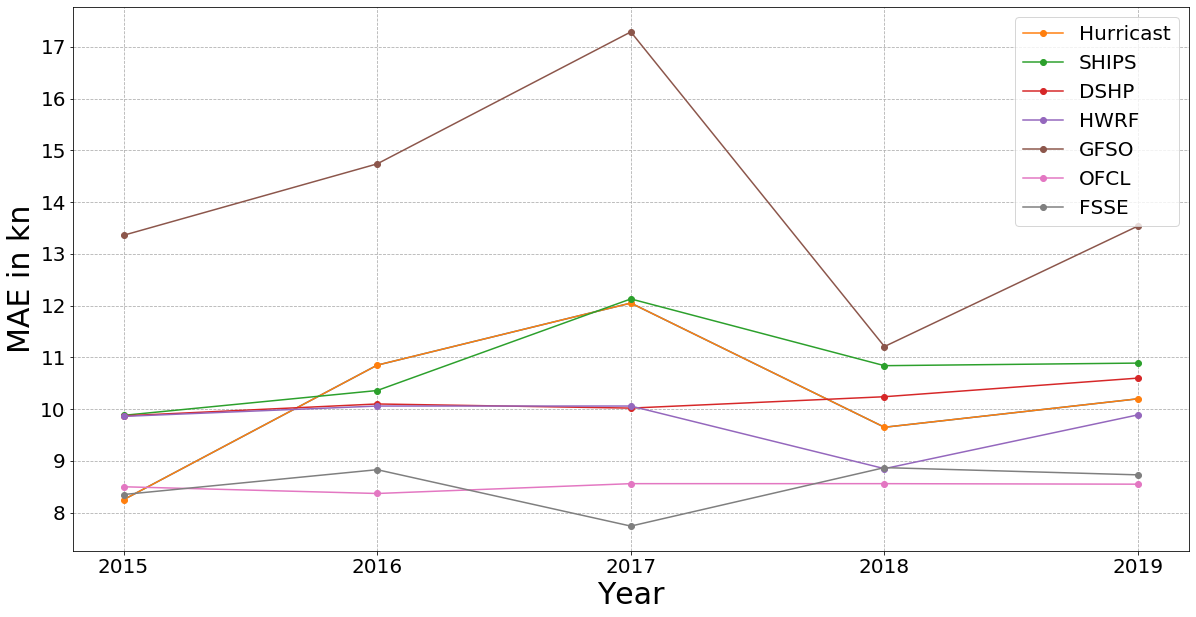

In [96]:
import matplotlib.pyplot as plt
years = [i for i in range(2015, 2020)]
plt.figure(figsize=(20,10))
plt.xticks(years, fontsize = 20)
plt.yticks([i for i in range(19)], fontsize = 20)
#plt.figtext(.5,.9,"Mean Average Error in km between 2015 and 2019 for different \n North Atlantic track forecast models with lead time 24h", fontsize=30, ha='center')
#plt.plot(years, d1['MAES_2012'], label = 'MAES_2012', marker='o')
plt.plot(years, a)
plt.plot(years, a, label = 'Hurricast', marker='o')
plt.plot(years, d1['MAES_SHIP'], label = 'SHIPS', marker='o')
plt.plot(years, d1['MAES_DSHP'], label = 'DSHP', marker='o')
plt.plot(years, d1['MAES_HWRF'], label = 'HWRF', marker='o')
plt.plot(years, d1['MAES_GFSO'], label = 'GFSO', marker='o')
plt.plot(years, d1['MAES_OFCL'], label = 'OFCL', marker='o')
plt.plot(years, d1['MAES_FSSE'], label = 'FSSE', marker='o')
plt.xlabel("Year", fontsize = 30)
plt.ylabel("MAE in kn", fontsize = 30)
plt.legend(loc=1, prop={'size': 20})
plt.grid(linestyle='--')
plt.savefig("MAE_AN_intensity_24.jpg", dpi = 300)
#plt.title("Mean Average Error in km between 2015 and 2019 for each forecast model")
plt.show()

In [65]:
d2 = train_xgb_intensity_all_years_full_train_6cast(forecast = 'SHIP', max_depth = 5, n_estimators = 200, learning_rate = 0.03, subsample = 0.7, min_child_weight=1, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  255
Year 2015 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.68 16.03 16.86
Hurr until 2012:  11.79 16.12 18.43
SHIP 12.75 17.89 17.65
HWRF 11.79 17.29 16.86
OFCL 10.42 15.35 11.37
FSSE 9.93 13.96 11.76
GFSO 15.62 20.14 25.49
DSHP 12.41 16.99 17.65
Consensus ofcl 10.27 14.72 12.94
Consensus Hurr 10.05 14.45 12.16


Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.85 13.4 14.29
Hurr until 2012:  9.89 13.43 15.56
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.49 11.57 9.84


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.05 12.8 11.38
Hurr until 2012:  9.1 13.06 10.78
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP

In [66]:
print(d2['MAEs_full'])
d2['MAES_2012']

[11.68, 9.85, 9.05, 12.37]


[11.79, 9.89, 9.1, 12.75]

In [57]:
b = [11.41, 9.56, 8.76, 11.98]

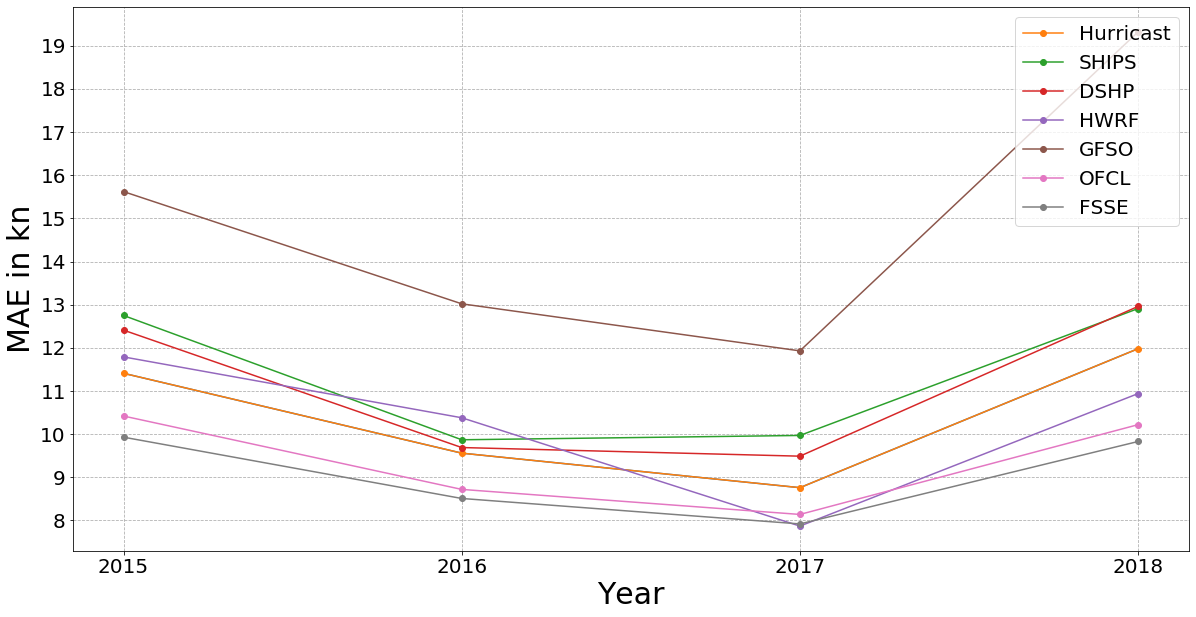

In [97]:
import matplotlib.pyplot as plt
years = [i for i in range(2015, 2019)]
plt.figure(figsize=(20,10))
plt.xticks(years, fontsize = 20)
plt.yticks([i for i in range(8,20)], fontsize = 20)
#plt.figtext(.5,.9,"Mean Average Error in km between 2015 and 2019 for different \n North Atlantic track forecast models with lead time 24h", fontsize=30, ha='center')
#plt.plot(years, d2['MAES_2012'], label = 'MAES_2012', marker='o')
plt.plot(years, b)
plt.plot(years, b, label = 'Hurricast', marker='o')
plt.plot(years, d2['MAES_SHIP'], label = 'SHIPS', marker='o')
plt.plot(years, d2['MAES_DSHP'], label = 'DSHP', marker='o')
plt.plot(years, d2['MAES_HWRF'], label = 'HWRF', marker='o')
plt.plot(years, d2['MAES_GFSO'], label = 'GFSO', marker='o')
plt.plot(years, d2['MAES_OFCL'], label = 'OFCL', marker='o')
plt.plot(years, d2['MAES_FSSE'], label = 'FSSE', marker='o')
plt.xlabel("Year", fontsize = 30)
plt.ylabel("MAE in kn", fontsize = 30)
plt.legend(loc=1, prop={'size': 20})
plt.grid(linestyle='--')
plt.savefig("MAE_EP_intensity_24.jpg", dpi = 300)
#plt.title("Mean Average Error in km between 2015 and 2019 for each forecast model")
plt.show()

# Figures 2017-2019

In [19]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_total, test = X_test_total, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 150, learning_rate = 0.07, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.1 15.3 18.5
Hurr until 2012:  11.95 15.14 19.38
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.58 11.38 8.37


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.81 12.76 13.25
Hurr until 2012:  9.97 13.03 12.39
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.12 11.2 8.55


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.6 13.66 11.54
Hurr until 2012:  10.36 13.5 10.1
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 10.6 1

In [17]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_total, test = X_test_total, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.07, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  11.93 15.19 19.38
Hurr until 2012:  11.72 14.93 18.06
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.58 11.36 7.93


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.95 12.89 12.82
Hurr until 2012:  10.05 13.09 11.97
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.15 11.22 8.55


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.51 13.46 10.1
Hurr until 2012:  10.07 13.12 10.58
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP

In [ ]:
#best d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_total, test = X_test_total, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.05, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')
#d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_total, test = X_test_total, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.07, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

In [20]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_total, test = X_test_total, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.03, subsample = 0.8, min_child_weight=1, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.17 15.62 19.38
Hurr until 2012:  11.96 15.22 18.5
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.59 11.42 7.93


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.75 12.78 13.25
Hurr until 2012:  9.74 12.84 13.25
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.11 11.2 8.55


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.19 13.37 10.1
Hurr until 2012:  10.27 13.49 9.13
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 10.

In [ ]:
a = [11.79, 9.64, 10.2]

In [33]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train, test = X_test, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.48 15.45 23.79
Hurr until 2012:  12.3 15.3 21.59
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.64 11.49 8.81


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.74 13.54 13.25
Hurr until 2012:  9.56 13.36 12.82
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.15 11.31 8.97


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.14 12.77 9.13
Hurr until 2012:  10.13 12.73 9.62
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 10.

In [32]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train, test = X_test, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 200, learning_rate = 0.03, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.6 15.63 22.91
Hurr until 2012:  12.59 15.51 22.47
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.65 11.51 9.69


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.77 13.75 13.68
Hurr until 2012:  9.58 13.19 12.39
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.14 11.34 9.4


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.38 13.06 11.06
Hurr until 2012:  10.13 12.91 10.58
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 1

In [34]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train, test = X_test, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 8, n_estimators = 300, learning_rate = 0.03, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.24 15.18 22.91
Hurr until 2012:  12.23 15.35 21.15
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.6 11.43 8.37


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.91 13.54 12.82
Hurr until 2012:  9.71 13.21 11.11
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.13 11.27 8.97


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.38 13.14 10.1
Hurr until 2012:  10.52 13.12 9.62
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 10

In [ ]:
#d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train, test = X_test, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.03, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

In [36]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_embed, test = X_test_embed, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.03, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.62 15.94 21.15
Hurr until 2012:  12.46 15.85 20.7
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.65 11.46 8.37


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.42 13.25 14.1
Hurr until 2012:  10.55 13.43 14.96
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.13 11.23 8.97


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.8 14.02 10.58
Hurr until 2012:  10.88 14.09 12.02
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 

In [37]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_embed, test = X_test_embed, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.05, subsample = 0.9, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.62 15.95 21.15
Hurr until 2012:  12.45 15.82 19.82
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.62 11.43 7.93


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.52 13.45 15.38
Hurr until 2012:  10.64 13.45 14.96
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.15 11.24 8.97


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.9 14.17 12.02
Hurr until 2012:  10.75 13.96 11.54
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSH

In [71]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_total_comp, test = X_test_total_comp, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', 
                                                    max_depth = 7, n_estimators = 300, learning_rate = 0.05, subsample = 0.9, min_child_weight=5, 
                                                    basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.0 14.82 22.47
Hurr until 2012:  12.0 14.82 22.47
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.55 11.39 8.37


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.51 13.02 11.97
Hurr until 2012:  9.6 13.15 11.54
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.06 11.2 9.4


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.84 12.54 7.69
Hurr until 2012:  9.99 12.65 8.17
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 10.6 13.

In [ ]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_total_comp, test = X_test_total_comp, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', 
                                                    max_depth = 7, n_estimators = 300, learning_rate = 0.05, subsample = 0.9, min_child_weight=1, 
                                                    basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

In [79]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = np.concatenate((X_train_total_comp, X_train), axis = 1), test = np.concatenate((X_test_total_comp, X_test), axis =1), tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', 
                                                    max_depth = 7, n_estimators = 300, learning_rate = 0.05, subsample = 0.9, min_child_weight=5, 
                                                    basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.0 14.82 22.47
Hurr until 2012:  12.0 14.82 22.47
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.55 11.39 8.37


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.51 13.02 11.97
Hurr until 2012:  9.6 13.15 11.54
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.06 11.2 9.4


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.84 12.54 7.69
Hurr until 2012:  9.99 12.65 8.17
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 10.6 13.

In [83]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = np.concatenate((X_train_total_comp, X_train, X_train_embed), axis = 1), test = np.concatenate((X_test_total_comp, X_test, X_test_embed), axis =1), tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', 
                                                    max_depth = 6, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, 
                                                    basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.26 15.67 20.26
Hurr until 2012:  12.26 15.67 20.26
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.63 11.42 8.37


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.73 12.8 12.82
Hurr until 2012:  9.7 12.71 12.82
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.07 11.17 8.55


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  10.59 13.74 10.1
Hurr until 2012:  10.52 13.63 9.62
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 10.

In [46]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_test_baseline[:m], test = X_test_baseline, tgt_train=tgt_intensity_test[:m], tgt_test = tgt_intensity_test, 
                                                    forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.05, subsample = 0.9, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.31 16.21 21.59
Hurr until 2012:  12.31 16.21 21.59
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.56 11.49 7.93


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.29 12.81 13.25
Hurr until 2012:  9.27 12.27 11.97
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.18 11.36 8.97


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  8.94 12.15 7.21
Hurr until 2012:  9.56 13.28 10.1
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 10.

In [66]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_test_baseline[:m], test = X_test_baseline, tgt_train=tgt_intensity_test[:m], tgt_test = tgt_intensity_test, 
                                                    forecast = 'SHIP', max_depth = 8, n_estimators = 250, learning_rate = 0.03, subsample = 0.8, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.21 16.38 22.03
Hurr until 2012:  12.21 16.38 22.03
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.55 11.52 8.37


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.21 12.72 12.39
Hurr until 2012:  9.15 12.44 11.11
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.21 11.38 8.55


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  8.76 12.09 8.65
Hurr until 2012:  10.13 13.51 10.58
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 1

In [54]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = np.concatenate((X_test_embed[:m], X_test_baseline[:m]), axis = 1), test = np.concatenate((X_test_embed, X_test_baseline), axis = 1), tgt_train=tgt_intensity_test[:m], tgt_test = tgt_intensity_test, 
                                                    forecast = 'SHIP', max_depth = 6, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  227
Year 2017 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  12.67 16.42 22.91
Hurr until 2012:  12.67 16.42 22.91
SHIP 12.13 16.94 19.82
HWRF 10.06 12.67 12.33
OFCL 8.56 11.82 6.61
FSSE 7.74 10.09 5.73
GFSO 17.29 17.77 31.28
DSHP 10.02 13.38 13.66
Consensus ofcl 8.45 11.32 8.37
Consensus Hurr 8.55 11.43 7.49


Total number of steps for comparison:  234
Year 2018 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.06 12.39 11.11
Hurr until 2012:  9.44 12.74 11.97
SHIP 10.84 15.02 14.53
HWRF 8.85 12.42 9.83
OFCL 8.56 12.13 8.12
FSSE 8.87 12.21 8.97
GFSO 11.21 12.87 14.96
DSHP 10.24 13.42 14.1
Consensus ofcl 8.36 11.51 8.97
Consensus Hurr 8.18 11.36 8.97


Total number of steps for comparison:  208
Year 2019 Basin AN MAE intensity | std | busts > 20kn %
Hurr full:  9.06 12.56 9.62
Hurr until 2012:  9.85 13.0 9.13
SHIP 10.89 14.22 17.79
HWRF 9.89 12.68 11.54
OFCL 8.55 11.53 7.21
FSSE 8.73 11.42 7.21
GFSO 13.54 15.47 21.15
DSHP 10.6

In [ ]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = np.concatenate((X_test_embed[:m], X_test_baseline[:m]), axis = 1), test = np.concatenate((X_test_, X_test_baseline), axis = 1), tgt_train=tgt_intensity_test[:m], tgt_test = tgt_intensity_test, 
                                                    forecast = 'SHIP', max_depth = 6, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, basin = 'AN', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

# Consensus

In [192]:
train = X_train
test = X_test
tgt_train = tgt_intensity_train
xgb_total = XGBRegressor(max_depth=6, n_estimators=300, learning_rate=0.03,
                             subsample=0.9, min_child_weight=5)
xgb_total.fit(np.array(train), tgt_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.03, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=nan, monotone_constraints='()',
       n_estimators=300, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.9,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [193]:
train = X_train_total
test2 = X_test_total
tgt_train = tgt_intensity_train
xgb_total_2 = XGBRegressor(max_depth=8, n_estimators=300, learning_rate=0.03,
                             subsample=0.8, min_child_weight=5)
xgb_total_2.fit(np.array(train), tgt_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.03, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=nan, monotone_constraints='()',
       n_estimators=300, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.8,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [194]:
year = 2018
forecast='SHIP'
forecast2 = 'HWRF'
forecast3 = 'OFCL'
forecast4 = 'FSSE'
forecast5 = 'GFSO'
forecast6 = 'DSHP'
mode = 'vmax'
basin = 'EP'

if True:
    baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
    index = baseline_.index
    baseline_1 = baseline_[forecast + '_24_'+ mode + '_7']
    baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    baseline_3 = baseline_[forecast3 + '_24_' + mode + '_7']
    baseline_4 = baseline_[forecast4 + '_24_' + mode + '_7']
    baseline_5 = baseline_[forecast5 + '_24_' + mode + '_7']
    baseline_6 = baseline_[forecast6 + '_24_' + mode + '_7']
    X_test_withBASELINE_total = np.array(test)[index]
    X_test_withBASELINE_total_2 = np.array(test2)[index]
    
    tgt_ = np.array(tgt_intensity_test[index] * std_ + mean_)
    preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
    preds2 = xgb_total_2.predict(X_test_withBASELINE_total_2) * std_ + mean_
    train_consensus = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6), axis = 1)
    train_consensus_hurr = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, preds), axis = 1)
    train_consensus_hurr2 = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, preds, preds2), axis = 1)
    
    
if True:
    baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] == year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]  # .loc[#X_test_baseline['SHIP_24_'+mode+'_7'] > 0].index
    if basin == 'EP':
        baseline_ = X_test_baseline.loc[X_test_baseline['YEAR_0'] < 2019].loc[X_test_baseline['YEAR_0'] == year].loc[
            X_test_baseline[forecast6 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast5 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast4 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast3 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast2 + '_24_' + mode + '_7'] > -320].loc[
            X_test_baseline[forecast + '_24_' + mode + '_7'] > -320].loc[X_test_baseline['cat_basin_' + basin + '_0'] == 1]
    index = baseline_.index
    baseline_1 = baseline_[forecast + '_24_'+ mode + '_7']
    baseline_2 = baseline_[forecast2 + '_24_' + mode + '_7']
    baseline_3 = baseline_[forecast3 + '_24_' + mode + '_7']
    baseline_4 = baseline_[forecast4 + '_24_' + mode + '_7']
    baseline_5 = baseline_[forecast5 + '_24_' + mode + '_7']
    baseline_6 = baseline_[forecast6 + '_24_' + mode + '_7']
    X_test_withBASELINE_total = np.array(test)[index]
    X_test_withBASELINE_total_2 = np.array(test2)[index]
    
    tgt_test = np.array(tgt_intensity_test[index] * std_ + mean_)
    preds = xgb_total.predict(X_test_withBASELINE_total) * std_ + mean_
    preds2 = xgb_total_2.predict(X_test_withBASELINE_total_2) * std_ + mean_
    test_consensus = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6), axis = 1)
    test_consensus_hurr = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, preds), axis = 1)
    test_consensus_hurr2 = np.stack((baseline_1, baseline_2, baseline_3, baseline_4, baseline_5, baseline_6, preds, preds2), axis = 1)
        

In [202]:
#AN
m = Lasso(alpha = 0.001)
m.fit(train_consensus, tgt_)
preds = np.array(m.predict(test_consensus))
print("Number of timesteps", len(preds))
print("consensus without Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

m = Lasso(alpha = 0.00001, normalize = True)
m.fit(train_consensus_hurr, tgt_)
preds = np.array(m.predict(test_consensus_hurr))

print("consensus with Hurricast",
                np.around(mean_absolute_error(np.array(tgt_test), preds), decimals=2),
                np.around(np.std(tgt_test - preds), decimals=2),
                np.around(sum(abs(tgt_test - preds) > 20)/len(preds) * 100, decimals = 2))

m = Lasso(alpha = 0.005)
m.fit(train_consensus_hurr2, tgt_)
preds2 = np.array(m.predict(test_consensus_hurr2))


print("consensus with Hurricast 2",
                np.around(mean_absolute_error(np.array(tgt_test), preds2), decimals=2),
                np.around(np.std(tgt_test - preds2), decimals=2),
                np.around(sum(abs(tgt_test - preds2) > 20)/len(preds2) * 100, decimals = 2))

Number of timesteps 355
consensus without Hurricast 8.71 12.14 12.39
consensus with Hurricast 8.83 12.09 12.11
consensus with Hurricast 2 8.81 11.97 11.27


In [176]:
m.coef_

array([-0.07195349,  0.15597878,  0.        ,  0.85105306,  0.12767506,
       -0.17851734,  0.29833725, -0.        ], dtype=float32)

# EP

## Stat only


In [21]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train, test = X_test, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 8, n_estimators = 300, learning_rate = 0.05, subsample = 0.8, min_child_weight=5, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  10.08 13.87 14.92
Hurr until 2012:  10.08 13.87 14.92
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.54 11.68 9.52


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.43 13.25 10.18
Hurr until 2012:  9.33 13.2 8.98
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.52 10.57 5.99


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  12.42 16.21 22.54
Hurr until 2012:  12.53 16.23 20.56
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.9

In [22]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train, test = X_test, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 8, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  10.09 13.96 16.83
Hurr until 2012:  10.09 13.96 16.83
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.56 11.71 9.84


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.07 12.98 9.58
Hurr until 2012:  9.13 13.02 9.58
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.48 10.56 4.79


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  12.61 16.43 21.97
Hurr until 2012:  12.59 16.43 21.41
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.9

In [20]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train, test = X_test, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', max_depth = 8, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  10.09 13.96 16.83
Hurr until 2012:  10.09 13.96 16.83
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.56 11.71 9.84


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.07 12.98 9.58
Hurr until 2012:  9.13 13.02 9.58
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.48 10.56 4.79


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  12.61 16.43 21.97
Hurr until 2012:  12.59 16.43 21.41
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.9

## Total CNN/GRU

In [25]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_total, test = X_test_total, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', 
                                                    max_depth = 9, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.63 13.22 15.24
Hurr until 2012:  9.63 13.22 15.24
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.5 11.58 9.52


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  8.88 12.63 8.38
Hurr until 2012:  9.04 13.02 9.58
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.43 10.42 4.79


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  12.0 15.59 20.85
Hurr until 2012:  12.36 16.06 21.41
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.96 15

## Total tensor decomp

In [28]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_total_comp, test = X_test_total_comp, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', 
                                                    max_depth = 7, n_estimators = 150, learning_rate = 0.03, subsample = 0.8, min_child_weight=5, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  10.35 14.25 15.87
Hurr until 2012:  10.35 14.25 15.87
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.61 11.75 9.84


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.23 13.36 10.78
Hurr until 2012:  9.15 13.3 10.78
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.52 10.65 5.39


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  12.73 16.52 21.41
Hurr until 2012:  12.79 16.56 22.25
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.

## Embeds only

In [27]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_train_embed, test = X_test_embed, tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', 
                                                    max_depth = 7, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  10.07 13.52 15.56
Hurr until 2012:  10.07 13.52 15.56
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.45 11.53 9.52


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  8.77 12.63 8.98
Hurr until 2012:  8.95 12.97 9.58
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.41 10.42 4.79


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  12.61 16.09 22.54
Hurr until 2012:  12.72 16.2 22.54
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.96

In [40]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = np.concatenate((X_train_embed, X_train_total_comp), axis =1), test = np.concatenate((X_test_embed, X_test_total_comp), axis = 1), tgt_train=tgt_intensity_train, tgt_test = tgt_intensity_test, forecast = 'SHIP', 
                                                    max_depth = 7, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, 
                                                    basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.8 13.4 15.24
Hurr until 2012:  9.8 13.4 15.24
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.51 11.59 9.21


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  8.82 12.69 8.98
Hurr until 2012:  8.89 12.81 8.98
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.42 10.44 4.79


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  12.21 15.76 20.85
Hurr until 2012:  12.54 16.12 21.69
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.96 15.8

## Operational forecasts

In [59]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = X_test_baseline[:m], test = X_test_baseline, tgt_train=tgt_intensity_test[:m], tgt_test = tgt_intensity_test, 
                                                    forecast = 'SHIP', max_depth = 5, n_estimators = 150, learning_rate = 0.03, subsample = 0.8, min_child_weight=1, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.9 12.97 11.75
Hurr until 2012:  9.9 12.97 11.75
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.55 11.63 8.89


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  8.31 10.87 6.59
Hurr until 2012:  8.44 11.44 8.38
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.44 10.41 5.99


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  10.7 13.71 14.37
Hurr until 2012:  11.78 14.87 18.03
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.96 15.

In [60]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = np.concatenate((X_test_embed[:m], X_test_baseline[:m]), axis = 1), test = np.concatenate((X_test_embed, X_test_baseline), axis = 1), tgt_train=tgt_intensity_test[:m], tgt_test = tgt_intensity_test, 
                                                    forecast = 'SHIP', max_depth = 7, n_estimators = 300, learning_rate = 0.03, subsample = 1, min_child_weight=5, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.0 12.32 10.16
Hurr until 2012:  9.0 12.32 10.16
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.5 11.52 8.89


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  8.58 11.13 9.58
Hurr until 2012:  8.78 11.72 10.18
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.49 10.35 4.79


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  10.87 13.96 16.06
Hurr until 2012:  11.23 14.28 18.31
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.96 15

In [43]:
d1 = train_xgb_intensity_all_years_full_train_6cast(train = np.concatenate((x_viz_test[:m], X_test_baseline[:m]), axis = 1), test = np.concatenate((x_viz_test, X_test_baseline), axis = 1), tgt_train=tgt_intensity_test[:m], tgt_test = tgt_intensity_test, 
                                                    forecast = 'SHIP', max_depth = 8, n_estimators = 300, learning_rate = 0.03, subsample = 0.9, min_child_weight=5, basin = 'EP', forecast2 = 'HWRF', forecast3 = 'OFCL', forecast4 = 'FSSE', forecast5 = 'GFSO', forecast6 = 'DSHP')

Total number of steps for comparison:  315
Year 2016 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  9.92 13.16 11.11
Hurr until 2012:  9.92 13.16 11.11
SHIP 9.87 12.84 10.79
HWRF 10.38 13.74 11.75
OFCL 8.72 11.89 6.67
FSSE 8.51 11.53 8.57
GFSO 13.02 16.38 21.27
DSHP 9.69 12.58 10.16
Consensus ofcl 8.63 11.66 9.21
Consensus Hurr 8.54 11.6 8.89


Total number of steps for comparison:  167
Year 2017 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  8.52 10.99 11.38
Hurr until 2012:  9.25 12.11 10.78
SHIP 9.97 13.0 10.78
HWRF 7.87 11.61 8.38
OFCL 8.14 11.67 4.79
FSSE 7.92 10.67 4.79
GFSO 11.93 16.27 17.96
DSHP 9.49 12.71 10.18
Consensus ofcl 7.76 10.71 5.39
Consensus Hurr 7.45 10.37 5.39


Total number of steps for comparison:  355
Year 2018 Basin EP MAE intensity | std | busts > 20kn %
Hurr full:  11.39 14.7 17.75
Hurr until 2012:  11.84 14.97 19.44
SHIP 12.91 15.83 19.72
HWRF 10.94 14.86 16.9
OFCL 10.22 13.48 9.3
FSSE 9.83 12.64 12.39
GFSO 19.32 20.45 38.59
DSHP 12.96 

# SVR

In [49]:
from sklearn.svm import SVR

In [51]:
s = SVR()
s.fit(X_test[:m], tgt_intensity_test[:m])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [52]:
s.predict(X_test[m:])

array([-0.08784974, -0.08784974, -0.08784974, ..., -0.08784974,
       -0.08784974, -0.08784974])